Gwendal DECOURCHELLE \
Clément SEIMPERE     \
Dan     PERRIER      
=============================

In [2]:
#Import all necessary librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import yfinance as yf
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.tsa.stattools import acf
from scipy.stats import norm
import statsmodels.api as sm
import scipy.signal as ss
import seaborn as sns
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from hurst import compute_Hc
import matplotlib.dates as mdates

In [3]:
#Import Marriott's stock data from Yahoo Finance
Marriott = yf.download("MAR", start="1998-12-31" ,end="2024-12-31")

C:\Users\cleme\AppData\Local\Temp\ipykernel_19556\2452095793.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Marriott = yf.download("MAR", start="1998-12-31" ,end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [4]:
# Resize table and rename the Daily closing price
Pt_d_all = Marriott["Close"]
Pt_d_all = Pt_d_all.rename(columns={Pt_d_all.columns[0]: "Daily Close"})
Pt_d_all.index = pd.to_datetime(Pt_d_all.index)

Pt_m_all = Pt_d_all.resample('ME').last()
Pt_y_all = Pt_d_all.resample('YE').last()

In [5]:
#Daily log prices
pt_d_all = np.log(Pt_d_all).squeeze("columns")
pt_d_all.name = "pt.d.all"
#Monthly log prices
pt_m_all = pt_d_all.resample('ME').last()
pt_m_all.name = "pt.m.all"
#Yearly log prices
pt_y_all = pt_d_all.resample('YE').last()
pt_y_all.name = "pt.y.all"

#Daily Log returns
rt_d_all = pt_d_all.diff().dropna()
rt_d_all.name = "rt.d.all"
#Monthly Log returns
rt_m_all = pt_m_all.diff().dropna()
rt_m_all.name = "rt.m.all"
#Annualy Log returns
rt_y_all = pt_y_all.diff().dropna()
rt_y_all.name = "rt.y.all"

In [6]:
#Create sample characteristics table
ticker = "MAR"
stock = yf.Ticker(ticker)
Marriott = stock.history(period="max")

data = {
    "Stock": stock.info.get("longName"),
    "Ticker": stock.info.get("symbol"),
    "Country": stock.info.get("country"),
    "Market": stock.info.get("exchange"),
    "Devise": stock.info.get("currency"),
    "Initial date": rt_d_all.index.min().strftime("%Y-%m-%d"),
    "End date": rt_d_all.index.max().strftime("%Y-%m-%d"),
    "Length of sample (Days)": len(rt_d_all),
    "Length of sample (Months)": len(rt_m_all),
    "Length of sample (Years)": len(rt_y_all),
}
df_summary = pd.DataFrame(list(data.items()), columns=["", ""])
df_summary.iloc[:, 0] = df_summary.iloc[:, 0].astype(str)
max_len = df_summary.iloc[:, 0].str.len().max()
df_summary.iloc[:, 0] = df_summary.iloc[:, 0].str.ljust(max_len + 3)
print(df_summary.to_string(index=False))
df_summary = pd.DataFrame(df_summary)
df_summary

                                                         
Stock                        Marriott International, Inc.
Ticker                                                MAR
Country                                     United States
Market                                                NMS
Devise                                                USD
Initial date                                   1999-01-04
End date                                       2024-12-30
Length of sample (Days)                              6540
Length of sample (Months)                             312
Length of sample (Years)                               26


,,
0,Stock,"Marriott International, Inc."
1,Ticker,MAR
2,Country,United States
3,Market,NMS
4,Devise,USD
5,Initial date,1999-01-04
6,End date,2024-12-30
7,Length of sample (Days),6540
8,Length of sample (Months),312
9,Length of sample (Years),26


In [7]:
df_summary.to_latex("summary.tex",index=False)

In [8]:
#Create the statistical description of data

X = {
    'Daily': rt_d_all,
    'Monthly': rt_m_all,
    'Annual': rt_y_all}

def multi_fun(x):
    stat_tab = {
        'Mean': round(np.mean(x) * 100,5),
        'St.Deviation': round(np.std(x) * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(x) / len(x)) * 100,5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x, fisher=False),5),
        'Excess.Kurtosis': round(kurtosis(x, fisher=True),5),
        'Min': round(np.min(x) * 100,5),
        'Quant5': round(np.quantile(x, 0.05) * 100,5),
        'Quant25': round(np.quantile(x, 0.25) * 100,5),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Quant75': round(np.quantile(x, 0.75) * 100,5),
        'Quant95': round(np.quantile(x, 0.95) * 100,5),
        'Max': round(np.max(x) * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(x)[0],5),
        'Jarque.Bera.pvalue.X100': round(jarque_bera(x)[1] *100,5),
        'Lillie.test.stat': round(lilliefors(x)[0],5),
        'Lillie.test.pvalue.X100': round(lilliefors(x)[1] * 100,5),
        'N.obs': len(x) }
    return stat_tab 

# Compute dictionnary
statistics_dict = {}
statistics_dict = {
    key: multi_fun(data.iloc[0:]) 
    for key, data in X.items()}

statistics_df = pd.DataFrame(statistics_dict)
statistics_df

,Daily,Monthly,Annual
Mean,0.04999,1.04779,12.57343
St.Deviation,2.13473,8.71341,28.16096
Diameter.C.I.Mean,0.05174,0.96687,10.82473
Skewness,-0.11062,-0.41860,-0.64430
Kurtosis,11.12400,7.64914,2.33104
Excess.Kurtosis,8.12400,4.64914,-0.66896
Min,-23.63894,-50.53299,-54.94678
Quant5,-3.27442,-10.52729,-31.58696
Quant25,-0.94999,-3.98327,-12.49575
Median,0.05516,0.67590,22.67719


In [9]:
statistics_df.reset_index(inplace=True)
statistics_df.rename(columns={'index': ''}, inplace=True)
latex_statistics = statistics_df.to_latex("statistics.tex", index=False, escape=False, bold_rows=True)

### Stylized fact 2: returns stationary

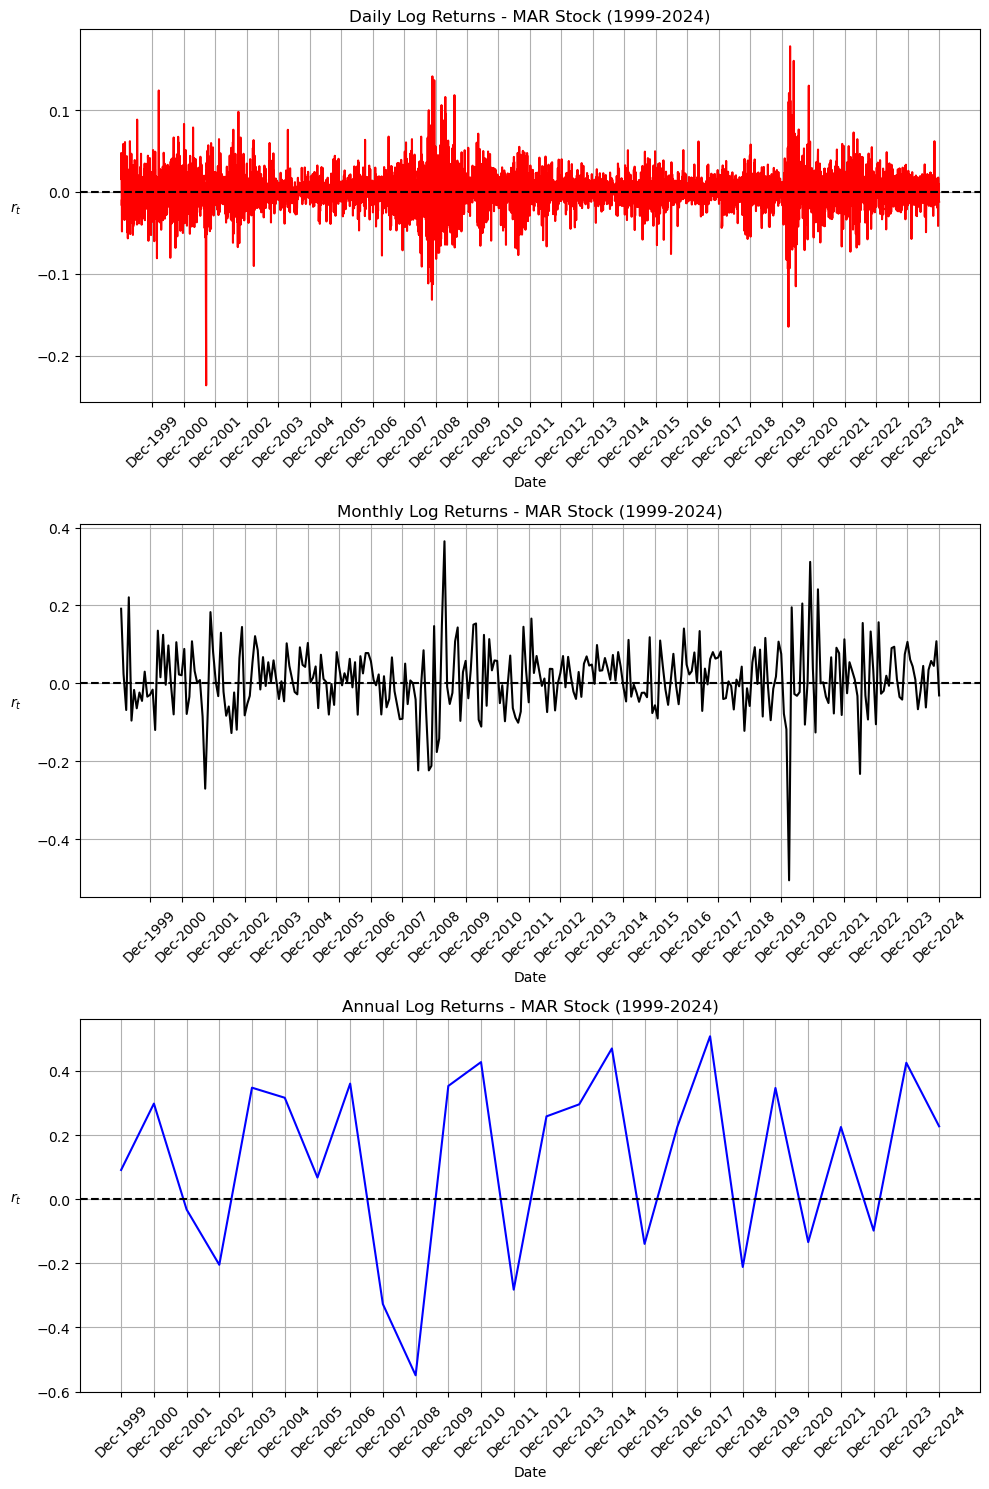

In [11]:
# Creating two plots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot of daily log returns
axs[0].plot(rt_d_all.index, rt_d_all, color='red')
axs[0].axhline(y=0, color='black', linestyle='--')
axs[0].set_title('Daily Log Returns - MAR Stock (1999-2024)')
axs[0].set_xlabel('Date')
axs[0].set_ylabel(r'$r_t$', rotation=0, labelpad=15)
axs[0].grid(True)

# Add "Dec-Year" at the end of each year (first plot)
date_labels = pd.date_range(start="1999-01-01", end="2024-12-31", freq='YE-DEC')
formatted_labels = [f'Dec-{date.year}' for date in date_labels]
axs[0].set_xticks(date_labels)
axs[0].set_xticklabels(formatted_labels, rotation=45)

# Plot of monthly log returns
axs[1].plot(rt_m_all.index, rt_m_all, color='black')
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_title('Monthly Log Returns - MAR Stock (1999-2024)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel(r'$r_t$', rotation=0, labelpad=15)
axs[1].grid(True)

# Add "Dec-Year" at the end of each year (second plot)
axs[1].set_xticks(date_labels)
axs[1].set_xticklabels(formatted_labels, rotation=45)

# Plot of annualy log returns
axs[2].plot(rt_y_all.index, rt_y_all, color='blue')
axs[2].axhline(y=0, color='black', linestyle='--')
axs[2].set_title('Annual Log Returns - MAR Stock (1999-2024)')
axs[2].set_xlabel('Date')
axs[2].set_ylabel(r'$r_t$', rotation=0, labelpad=15)
axs[2].grid(True)

# Add "Dec-Year" at the end of each year (second plot)
axs[2].set_xticks(date_labels)
axs[2].set_xticklabels(formatted_labels, rotation=45)

# Adjust spacing between plots
plt.tight_layout()
plt.show()

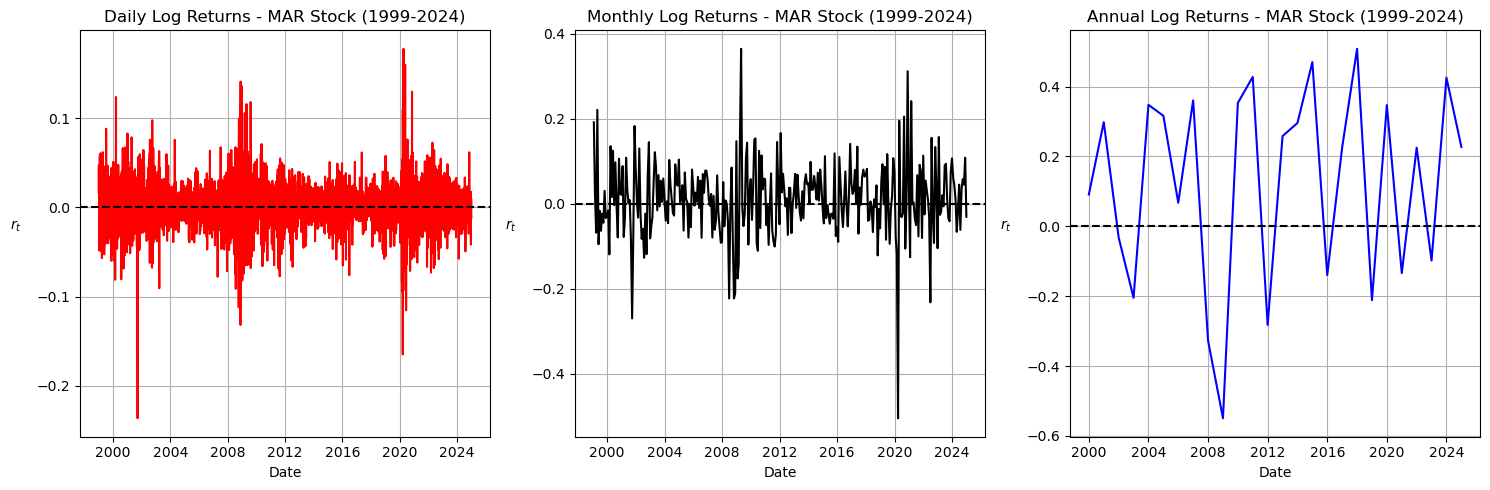

In [12]:
# Creating two plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot of daily log returns
axs[0].plot(rt_d_all.index, rt_d_all, color='red')
axs[0].axhline(y=0, color='black', linestyle='--')
axs[0].set_title('Daily Log Returns - MAR Stock (1999-2024)')
axs[0].set_xlabel('Date')
axs[0].set_ylabel(r'$r_t$', rotation=0, labelpad=15)
axs[0].grid(True)

# Plot of monthly log returns
axs[1].plot(rt_m_all.index, rt_m_all, color='black')
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_title('Monthly Log Returns - MAR Stock (1999-2024)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel(r'$r_t$', rotation=0, labelpad=15)
axs[1].grid(True)

# Plot of annualy log returns
axs[2].plot(rt_y_all.index, rt_y_all, color='blue')
axs[2].axhline(y=0, color='black', linestyle='--')
axs[2].set_title('Annual Log Returns - MAR Stock (1999-2024)')
axs[2].set_xlabel('Date')
axs[2].set_ylabel(r'$r_t$', rotation=0, labelpad=15)
axs[2].grid(True)

# Adjust spacing between plots
plt.tight_layout()
# Save the plot in png format
plt.savefig('Log_returns.png', format='png', bbox_inches='tight')
plt.show()

### Stylized fact 3 & 4: Asymmetry and Heavy Tails

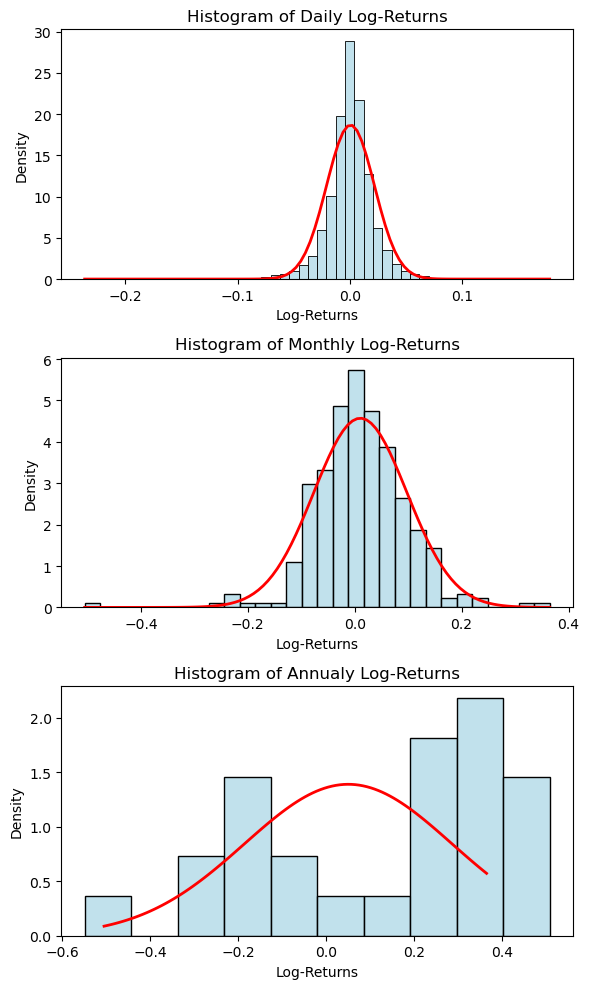

In [14]:
# Create the figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

# Plot histogram of daily log-returns
sns.histplot(rt_d_all, bins=50, color='lightblue', edgecolor='black', kde_kws={'color': 'red'}, ax=axs[0], stat='density')
axs[0].plot(np.linspace(rt_d_all.min(), rt_d_all.max(), 100),
               stats.norm.pdf(np.linspace(rt_d_all.min(), rt_d_all.max(), 100),
                              rt_d_all.mean(), rt_d_all.std()), color='red', linewidth=2)
axs[0].set_title('Histogram of Daily Log-Returns')
axs[0].set_xlabel('Log-Returns')
axs[0].set_ylabel('Density')

# Plot histogram of monthly log-returns
sns.histplot(rt_m_all, bins=30, color='lightblue', edgecolor='black', kde_kws={'color': 'red'}, ax=axs[1], stat='density')
axs[1].plot(np.linspace(rt_m_all.min(), rt_m_all.max(), 100),
               stats.norm.pdf(np.linspace(rt_m_all.min(), rt_m_all.max(), 100),
                              rt_m_all.mean(), rt_m_all.std()), color='red', linewidth=2)
axs[1].set_title('Histogram of Monthly Log-Returns')
axs[1].set_xlabel('Log-Returns')
axs[1].set_ylabel('Density')

# Plot histogram of annualy log-returns
sns.histplot(rt_y_all, bins=10, color='lightblue', edgecolor='black', kde_kws={'color': 'red'}, ax=axs[2], stat='density')
axs[2].plot(np.linspace(rt_m_all.min(), rt_m_all.max(), 100),
               stats.norm.pdf(np.linspace(rt_y_all.min(), rt_y_all.max(), 100),
                              rt_y_all.mean(), rt_y_all.std()), color='red', linewidth=2)
axs[2].set_title('Histogram of Annualy Log-Returns')
axs[2].set_xlabel('Log-Returns')
axs[2].set_ylabel('Density')

# Adjust spacing between plots
plt.tight_layout()
plt.show()

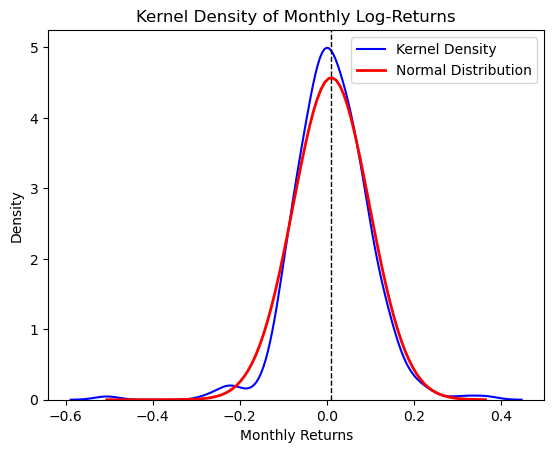

In [15]:
# Compute the empirical mean and std (monthly)
mean_empirical = rt_m_all.mean()
std_empirical = rt_m_all.std()

#Kernel density plot (monthly)
sns.kdeplot(rt_m_all, color='blue', label='Kernel Density')
x = np.arange(-0.06, 0.06, 0.001)
plt.plot(np.linspace(rt_m_all.min(), rt_m_all.max(), 100), stats.norm.pdf(np.linspace(rt_m_all.min(), rt_m_all.max(), 100),
                                                                               rt_m_all.mean(), rt_m_all.std()), color='red', linewidth=2, label='Normal Distribution')
plt.axvline(x=mean_empirical, color='black', linestyle='--', linewidth=1)
plt.xlabel('Monthly Returns')
plt.ylabel('Density')
plt.title('Kernel Density of Monthly Log-Returns')
plt.legend()

plt.savefig('Kernel_density_monthly.png', format='png', bbox_inches='tight')
plt.show()

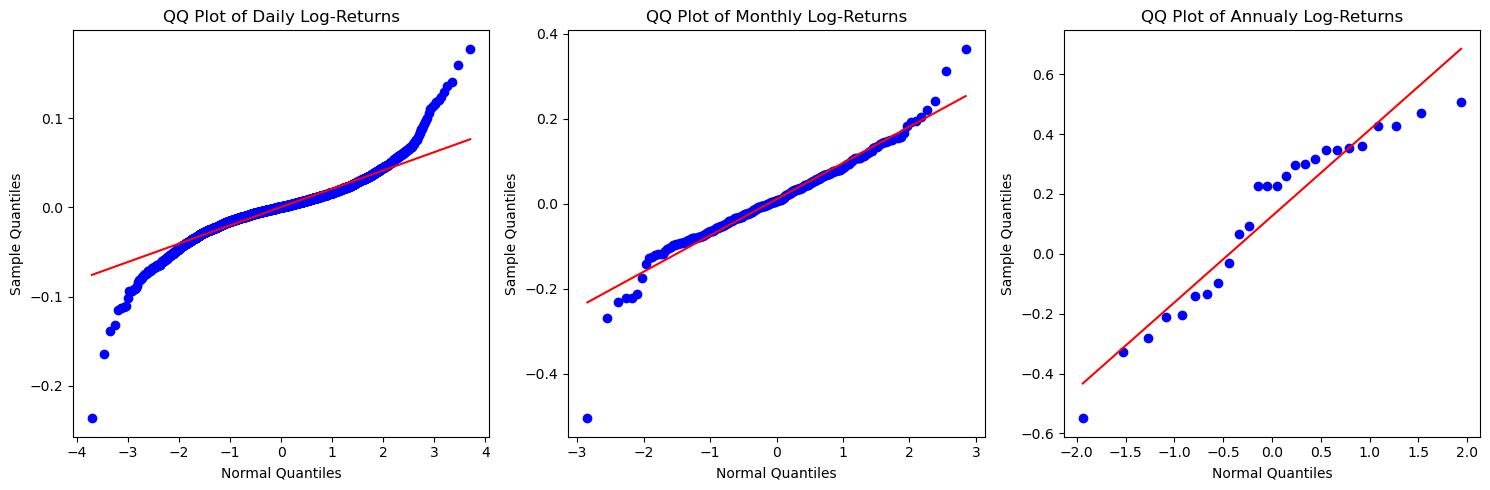

In [16]:
# Create the figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# QQ plot of daily log-returns
qqplot_axes = stats.probplot(rt_d_all, dist="norm", plot=axs[0])
axs[0].set_title('QQ Plot of Daily Log-Returns')
axs[0].set_xlabel('Normal Quantiles')
axs[0].set_ylabel('Sample Quantiles')

# QQ plot of monthly log-returns
qqplot_axes = stats.probplot(rt_m_all, dist="norm", plot=axs[1])
axs[1].set_title('QQ Plot of Monthly Log-Returns')
axs[1].set_xlabel('Normal Quantiles')
axs[1].set_ylabel('Sample Quantiles')

# QQ plot of annualy log-returns
qqplot_axes = stats.probplot(rt_y_all, dist="norm", plot=axs[2])
axs[2].set_title('QQ Plot of Annualy Log-Returns')
axs[2].set_xlabel('Normal Quantiles')
axs[2].set_ylabel('Sample Quantiles')

# Adjust spacing between plots
plt.tight_layout()

# Save the plot in png format
plt.savefig('QQ-plot.png', format='png', bbox_inches='tight')
plt.show()

In [17]:
#Summary

def multi_fun_2(x):
    stat_tab = {
        'Mean': round(np.mean(x)*100,4),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Skewness': round(skew(x),4),
        'Kurtosis': round(kurtosis(x, fisher=False),4),
        'Excess Kurtosis': round(kurtosis(x, fisher=True),4),
    }
    return stat_tab 

sf_3_dict = {}
sf_3_dict = {
    key: multi_fun_2(data.iloc[0:]) 
    for key, data in X.items()}

sf_3_df = pd.DataFrame(sf_3_dict)
sf_3_df

,Daily,Monthly,Annual
Mean,0.05000,1.0478,12.57340
Median,0.05516,0.6759,22.67719
Skewness,-0.11060,-0.4186,-0.64430
Kurtosis,11.12400,7.6491,2.33100
Excess Kurtosis,8.12400,4.6491,-0.66900


In [18]:
sf_3_df.reset_index(inplace=True)
sf_3_df.rename(columns={'index': ''}, inplace=True)
sf_3_df.to_latex("sf3.tex", index=False, escape=False, bold_rows=True)

###  Stylized fact 5: Aggregational Gaussianity 

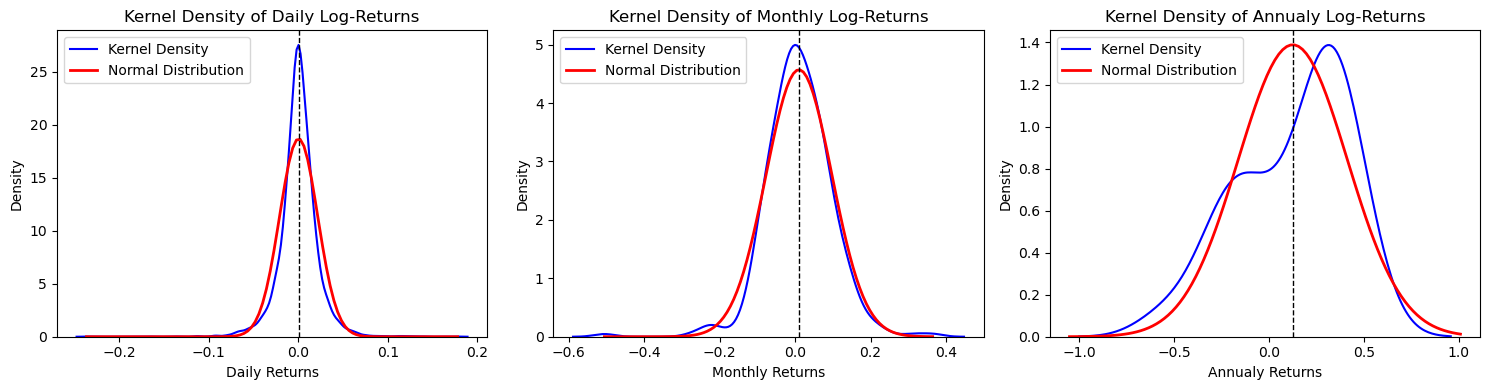

In [20]:
# Compute the empirical mean and std (daily)
mean_empirical = rt_d_all.mean()
std_empirical = rt_d_all.std()

# Define the layout: 1 row three columns
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

#Kernel density plot (daily)
sns.kdeplot(rt_d_all, color='blue', ax=axs[0],label='Kernel Density')
x = np.arange(-0.06, 0.06, 0.001)
axs[0].plot(np.linspace(rt_d_all.min(), rt_d_all.max(), 100), stats.norm.pdf(np.linspace(rt_d_all.min(), rt_d_all.max(), 100),
                                                                               rt_d_all.mean(), rt_d_all.std()), color='red', linewidth=2, label='Normal Distribution')
axs[0].axvline(x=mean_empirical, color='black', linestyle='--', linewidth=1)
axs[0].set_xlabel('Daily Returns')
axs[0].set_ylabel('Density')
axs[0].set_title('Kernel Density of Daily Log-Returns')
axs[0].legend()

# Compute the empirical mean and std (monthly)
mean_empirical = rt_m_all.mean()
std_empirical = rt_m_all.std()

#Kernel density plot (monthly)
sns.kdeplot(rt_m_all, color='blue', ax=axs[1], label='Kernel Density')
x = np.arange(-0.06, 0.06, 0.001)
axs[1].plot(np.linspace(rt_m_all.min(), rt_m_all.max(), 100), stats.norm.pdf(np.linspace(rt_m_all.min(), rt_m_all.max(), 100),
                                                                               rt_m_all.mean(), rt_m_all.std()), color='red', linewidth=2, label='Normal Distribution')
axs[1].axvline(x=mean_empirical, color='black', linestyle='--', linewidth=1)
axs[1].set_xlabel('Monthly Returns')
axs[1].set_ylabel('Density')
axs[1].set_title('Kernel Density of Monthly Log-Returns')
axs[1].legend()

# Compute the empirical mean and std (annualy)
mean_empirical = rt_y_all.mean()
std_empirical = rt_y_all.std()

#Kernel density plot (annualy)
sns.kdeplot(rt_y_all, color='blue', ax=axs[2],label='Kernel Density')
x = np.arange(-0.06, 0.06, 0.001)
axs[2].plot(np.linspace(rt_y_all.min()-0.5, rt_y_all.max()+0.5, 100), stats.norm.pdf(np.linspace(rt_y_all.min()-0.5, rt_y_all.max()+0.5, 100),
                                                                               rt_y_all.mean(), rt_y_all.std()), color='red', linewidth=2, label='Normal Distribution')
axs[2].axvline(x=mean_empirical, color='black', linestyle='--', linewidth=1)
axs[2].set_xlabel('Annualy Returns')
axs[2].set_ylabel('Density')
axs[2].set_title('Kernel Density of Annualy Log-Returns')
axs[2].legend()

plt.tight_layout()
plt.savefig('Kernel_density.png', format='png', bbox_inches='tight')
plt.show()

In [21]:
#Conclusion

def multi_fun_5(x):
    stat_tab = {
        'Jarque-Bera stat': round(jarque_bera(x)[0],4),
        'Jarque-Bera p-value': round(jarque_bera(x)[1],4),
        'KS stat': round(kstest(x, 'norm')[0],4),
        'KS p-value':round(kstest(x, 'norm')[1],4),
        'Lilliefors stat': round(lilliefors(x)[0],4),
        'Lilliefors p-value': round(lilliefors(x)[1],4),
    }
    return stat_tab 

# Compute dictionnary

sf5_dict = {}
sf5_dict = {
    key: multi_fun_5(data.iloc[0:]) 
    for key, data in X.items()}

sf5_df = pd.DataFrame(sf5_dict)
sf5_df

,Daily,Monthly,Annual
Jarque-Bera stat,17998.1844,290.1005,2.2837
Jarque-Bera p-value,0.0000,0.0000,0.3192
KS stat,0.4678,0.4237,0.3333
KS p-value,0.0000,0.0000,0.0045
Lilliefors stat,0.0764,0.0511,0.2124
Lilliefors p-value,0.0010,0.0705,0.0040


In [22]:
sf5_df.reset_index(inplace=True)
sf5_df.rename(columns={'index': ''}, inplace=True)
sf5_df.to_latex("sf5.tex", index=False, escape=False, bold_rows=True)

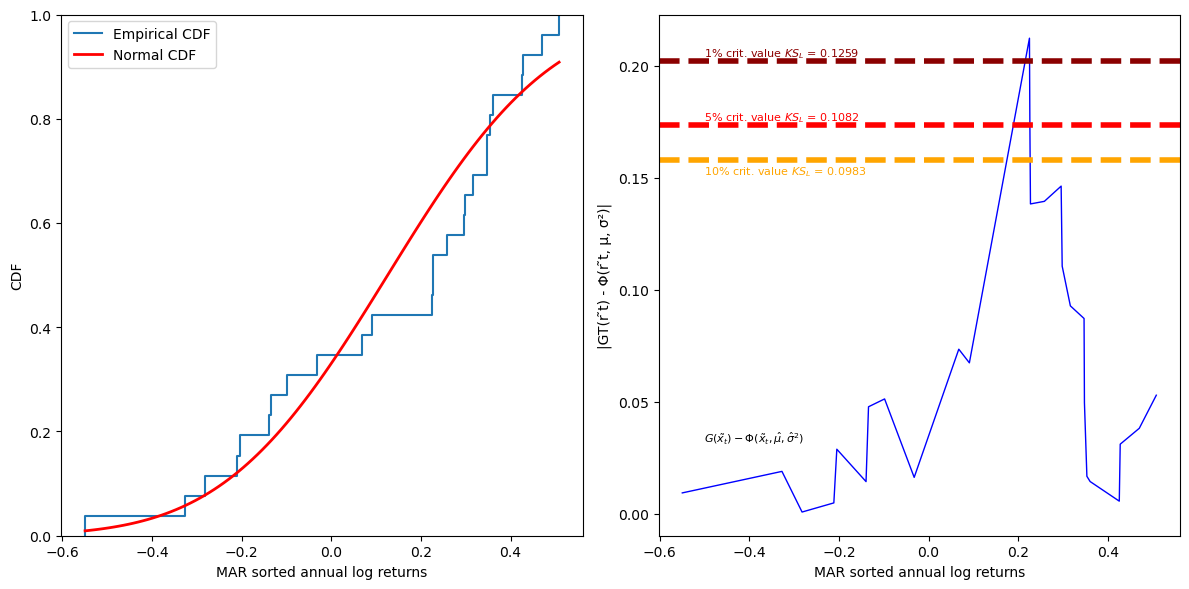

In [23]:
# Compute mean and std
mean_data = rt_y_all.mean()
sd_data = rt_y_all.std()
samp_size = len(rt_y_all)
seq_ind = np.arange(1, samp_size + 1, 1)
emp_cdf = seq_ind / samp_size
emp_cdf_2 = (seq_ind - 1) / samp_size
my_data_ordered = np.sort(rt_y_all)
theor_cdf = stats.norm.cdf(my_data_ordered, mean_data, sd_data)

# Set the layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left panel: empirical and Normal cdf's
sns.ecdfplot(rt_y_all, ax=axs[0], label='Empirical CDF')
axs[0].plot(np.linspace(rt_y_all.min(), rt_y_all.max(), 100),
            stats.norm.cdf(np.linspace(rt_y_all.min(), rt_y_all.max(), 100),
                           mean_data, sd_data),
            color='red', linewidth=2, label='Normal CDF')
axs[0].set_xlabel('MAR sorted annual log returns')
axs[0].set_ylabel('CDF')
axs[0].set_title('')
axs[0].legend()

# Right panel: Lilliefors test
KS_L_stat1 = np.max(np.abs(emp_cdf - theor_cdf))
KS_L_stat2 = np.max(np.abs(emp_cdf_2 - theor_cdf))
KS_L_stat = max(KS_L_stat1, KS_L_stat2)
axs[1].plot(my_data_ordered, np.abs(emp_cdf_2 - theor_cdf), color='blue', linewidth=1)
axs[1].axhline(y=0.805/np.sqrt(samp_size), color='orange', linewidth=4, linestyle='--')
axs[1].axhline(y=0.886/np.sqrt(samp_size), color='red', linewidth=4, linestyle='--')
axs[1].axhline(y=1.031/np.sqrt(samp_size), color='darkred', linewidth=4, linestyle='--')
axs[1].text(-0.5, 0.805/np.sqrt(samp_size)-0.006, '10% crit. value $KS_L$ = 0.0983', fontsize=8, color='orange')
axs[1].text(-0.5, 0.886/np.sqrt(samp_size)+0.002, '5% crit. value $KS_L$ = 0.1082', fontsize=8, color='red')
axs[1].text(-0.5, 1.031/np.sqrt(samp_size)+0.002, '1% crit. value $KS_L$ = 0.1259', fontsize=8, color='darkred')
axs[1].text(-0.5, 0.032, '$ G(\\tilde{x}_t)-\\Phi(\\tilde{x}_t, \\hat{\\mu}, \\hat{\\sigma}^2)$', fontsize=8)
axs[1].set_xlabel('MAR sorted annual log returns')
axs[1].set_ylabel('|GT(r ̃t) - Φ(r ̃t, μ, σ²)|')
axs[1].set_title('')

plt.tight_layout()
plt.savefig('CDF.png', format='png', bbox_inches='tight')
plt.show()

### Stylized fact 6: Returns are not autocorrelated

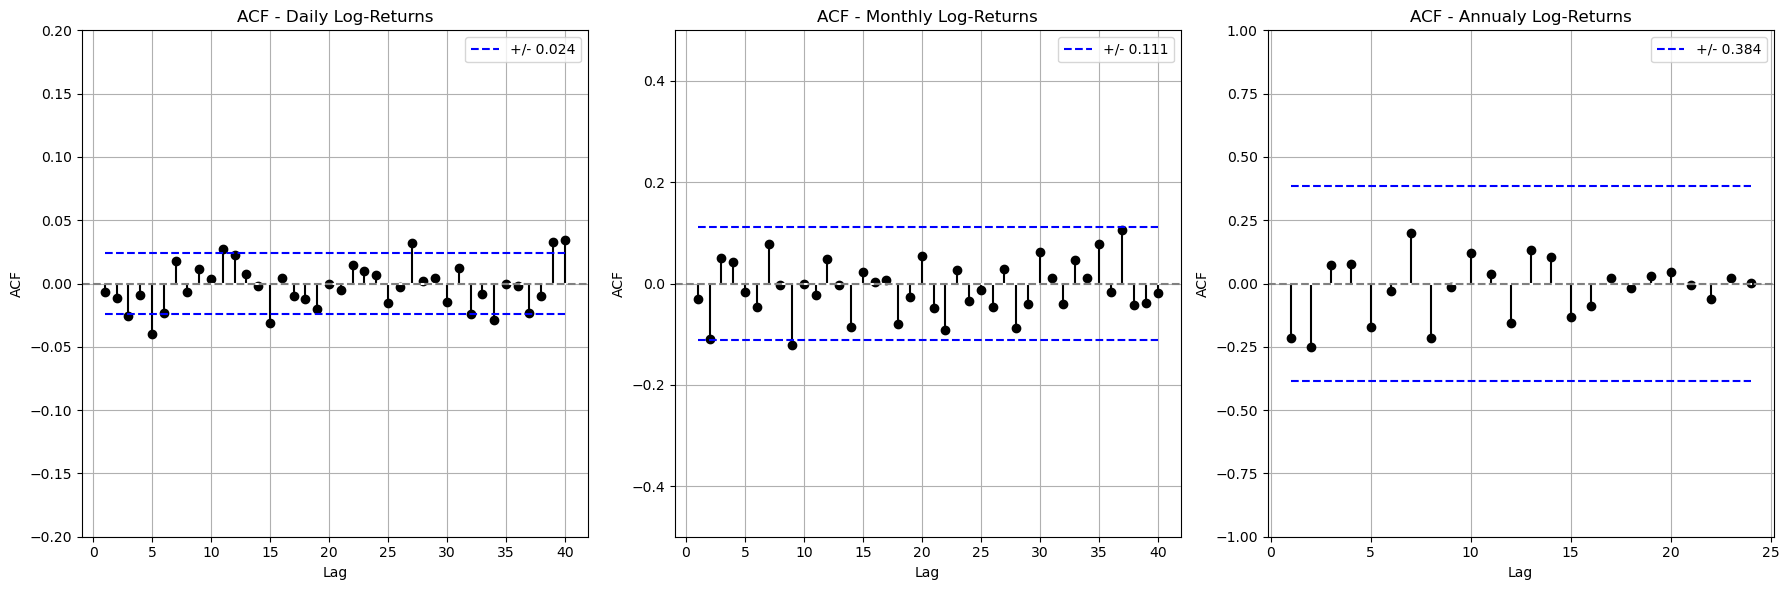

In [25]:
# Set the layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Compute the empirical ACF
lags = 40

# ACF of daily Log-returns
acf_values_daily = acf(rt_d_all, nlags=lags)
confint = 1.96 / np.sqrt(len(rt_d_all))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed',label = f'+/- {round(confint,3)}')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.2, 0.2)
axs[0].set_title('ACF - Daily Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].legend()
axs[0].grid(True)

# ACF of monthly log-returns
acf_values_monthly = acf(rt_m_all, nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_m_all))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)

axs[1].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed',label = f'+/- {round(confint_monthly,3)}')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.5, 0.5)
axs[1].set_title('ACF - Monthly Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].legend()
axs[1].grid(True)

lags_2=24
# ACF of annualy log-returns
acf_values_annualy = acf(rt_y_all, nlags=lags_2)
confint_annualy = 1.96 / np.sqrt(len(rt_y_all))
confint_annualy_upper = np.full(lags_2, confint_annualy)
confint_annualy_lower = -np.full(lags_2, confint_annualy)

axs[2].stem(np.arange(1, lags_2 + 1), acf_values_annualy[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, lags_2 + 1), confint_annualy_upper, color='blue', linestyle='dashed',label = f'+/- {round(confint_annualy,3)}')
axs[2].plot(np.arange(1, lags_2 + 1), confint_annualy_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-1, 1)
axs[2].set_title('ACF - Annualy Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.savefig('autocorrolation.png', format='png', bbox_inches='tight')
plt.show()

In [26]:
#Conclusion lag=10

def multi_fun_6(x):
    stat_tab = {
        'B-P stat': round(sm.stats.acorr_ljungbox(x, lags=[10], boxpierce=True)['bp_stat'].iloc[0],4),
        'B-P p-value': round(sm.stats.acorr_ljungbox(x, lags=[10], boxpierce=True)['bp_pvalue'].iloc[0],4),
        'L-B stat': round(sm.stats.acorr_ljungbox(x, lags=[10], boxpierce=True)['lb_stat'].iloc[0],4),
        'L-B p-value': round(sm.stats.acorr_ljungbox(x, lags=[10], boxpierce=True)['lb_pvalue'].iloc[0],4),
    }
    return stat_tab 

# Compute dictionnary

sf6_dict = {}
sf6_dict = {
    key: multi_fun_6(data.iloc[0:]) 
    for key, data in X.items()}

sf6_df = pd.DataFrame(sf6_dict)
sf6_df

,Daily,Monthly,Annual
B-P stat,23.2140,12.5080,6.6168
B-P p-value,0.0100,0.2525,0.7611
L-B stat,23.2388,12.8217,8.8438
L-B p-value,0.0099,0.2338,0.5470


In [27]:
sf6_df.reset_index(inplace=True)
sf6_df.rename(columns={'index': ''}, inplace=True)
sf6_df.to_latex("sf6.tex", index=False, escape=False, bold_rows=True)

In [28]:
#Daily
my_max_lag = 15
lags_all = np.arange(1, my_max_lag + 1)
my_acf_d = sm.tsa.acf(rt_d_all, nlags=my_max_lag)
my_acf_diameter_d = 1.96 / np.sqrt(len(rt_d_all))
my_acf_tstat_0_d = (my_acf_d[1:] - 0) / np.sqrt(1 / len(rt_d_all))
my_LjungBox_d = sm.stats.diagnostic.acorr_ljungbox(rt_d_all, lags=lags_all, boxpierce=False)
my_BoxPierce_d = sm.stats.diagnostic.acorr_ljungbox(rt_d_all, lags=lags_all, boxpierce=True)
crit_value_5_BP_d = stats.chi2.ppf(0.95,lags_all)

#Monthly
my_max_lag = 15
lags_all = np.arange(1, my_max_lag + 1)
my_acf_m = sm.tsa.acf(rt_m_all, nlags=my_max_lag)
my_acf_diameter_m = 1.96 / np.sqrt(len(rt_m_all))
my_acf_tstat_0_m = (my_acf_m[1:] - 0) / np.sqrt(1 / len(rt_m_all))
my_LjungBox_m = sm.stats.diagnostic.acorr_ljungbox(rt_m_all, lags=lags_all, boxpierce=False)
my_BoxPierce_m = sm.stats.diagnostic.acorr_ljungbox(rt_m_all, lags=lags_all, boxpierce=True)
crit_value_5_BP_m = stats.chi2.ppf(0.95,lags_all)

my_table = np.column_stack((
    lags_all,
    my_acf_d[1:],
    my_acf_tstat_0_d,
    my_BoxPierce_d['bp_stat'],
    my_BoxPierce_d['bp_pvalue'],
    my_LjungBox_d['lb_stat'],
    my_LjungBox_d['lb_pvalue'],
    np.full(my_max_lag, crit_value_5_BP_d),
    lags_all,
    my_acf_m[1:],
    my_acf_tstat_0_m,
    my_BoxPierce_m['bp_stat'],
    my_BoxPierce_m['bp_pvalue'],
    my_LjungBox_m['lb_stat'],
    my_LjungBox_m['lb_pvalue'],
    np.full(my_max_lag, crit_value_5_BP_m)
))
column_names = ["lag_daily", "acf", "acf test", "B-P stat", "B-P pval", "L-B stat", "L-B pval", "crit", "lag_monthly", "acf", "acf test", "B-P stat", "B-P pval", "L-B stat", "L-B pval", "crit"]
my_table_df = pd.DataFrame(data=my_table, columns=column_names)

# Print the rounded table
my_table_df = my_table_df.round(3)
my_table_df

,lag_daily,acf,acf test,B-P stat,B-P pval,L-B stat,L-B pval,crit,lag_monthly,acf,acf test,B-P stat,B-P pval,L-B stat,L-B pval,crit
0,1.0,-0.006,-0.522,0.273,0.601,0.273,0.601,3.841,1.0,-0.030,-0.525,0.276,0.600,0.278,0.598,3.841
1,2.0,-0.012,-0.932,1.141,0.565,1.142,0.565,5.991,2.0,-0.109,-1.927,3.991,0.136,4.041,0.133,5.991
2,3.0,-0.026,-2.104,5.567,0.135,5.571,0.134,7.815,3.0,0.051,0.902,4.805,0.187,4.868,0.182,7.815
3,4.0,-0.009,-0.714,6.077,0.193,6.082,0.193,9.488,4.0,0.042,0.735,5.345,0.254,5.420,0.247,9.488
4,5.0,-0.040,-3.197,16.297,0.006,16.312,0.006,11.070,5.0,-0.017,-0.305,5.438,0.365,5.514,0.356,11.070
5,6.0,-0.023,-1.898,19.898,0.003,19.918,0.003,12.592,6.0,-0.046,-0.811,6.096,0.412,6.190,0.402,12.592
6,7.0,0.018,1.441,21.974,0.003,21.997,0.003,14.067,7.0,0.077,1.367,7.964,0.336,8.113,0.323,14.067
7,8.0,-0.006,-0.521,22.246,0.004,22.269,0.004,15.507,8.0,-0.003,-0.053,7.967,0.437,8.116,0.422,15.507
8,9.0,0.012,0.946,23.141,0.006,23.166,0.006,16.919,9.0,-0.121,-2.131,12.508,0.186,12.822,0.171,16.919
9,10.0,0.003,0.270,23.214,0.010,23.239,0.010,18.307,10.0,-0.000,-0.007,12.508,0.252,12.822,0.234,18.307


In [29]:
#Realisation of LjungBox and BoxPierce tests for different lags
my_max_lag = 100
lags_all = np.arange(1, my_max_lag + 1)

my_acf = sm.tsa.acf(rt_d_all, nlags=my_max_lag)
my_acf_diameter = 1.96 / np.sqrt(len(rt_d_all))
my_acf_tstat_0 = (my_acf[1:] - 0) / np.sqrt(1 / len(rt_d_all))
my_LjungBox = sm.stats.diagnostic.acorr_ljungbox(rt_d_all, lags=lags_all, boxpierce=False)
my_BoxPierce = sm.stats.diagnostic.acorr_ljungbox(rt_d_all, lags=lags_all, boxpierce=True)
crit_value_5_BP = stats.chi2.ppf(0.95, lags_all)

my_table = np.column_stack((
    lags_all,
    my_acf[1:],
    np.full(my_max_lag, my_acf_diameter),
    my_acf_tstat_0,
    my_BoxPierce['bp_stat'],
    my_BoxPierce['bp_pvalue'],
    my_LjungBox['lb_stat'],
    my_LjungBox['lb_pvalue'],
    crit_value_5_BP
))

column_names = ["lag", "acf", "acf diam.", "acf test", "B-P stat", "B-P pval", "L-B stat", "L-B pval", "crit"]
my_table_df = pd.DataFrame(data=my_table, columns=column_names)

lags_to_display = [1, 5, 10]
lags_to_display = [lag for lag in lags_to_display if lag <= my_max_lag]  # sécurité

my_table_filtered = my_table_df[my_table_df["lag"].isin(lags_to_display)]

my_table_filtered = my_table_filtered.round(3)
my_table_filtered

,lag,acf,acf diam.,acf test,B-P stat,B-P pval,L-B stat,L-B pval,crit
0,1.0,-0.006,0.024,-0.522,0.273,0.601,0.273,0.601,3.841
4,5.0,-0.040,0.024,-3.197,16.297,0.006,16.312,0.006,11.070
9,10.0,0.003,0.024,0.270,23.214,0.010,23.239,0.010,18.307


In [30]:
my_table_filtered.to_latex("my_table_lags.tex", index=False, float_format="%.3f")

### Stylized fact 7: Volatility clustering and long range dependence of squared returns

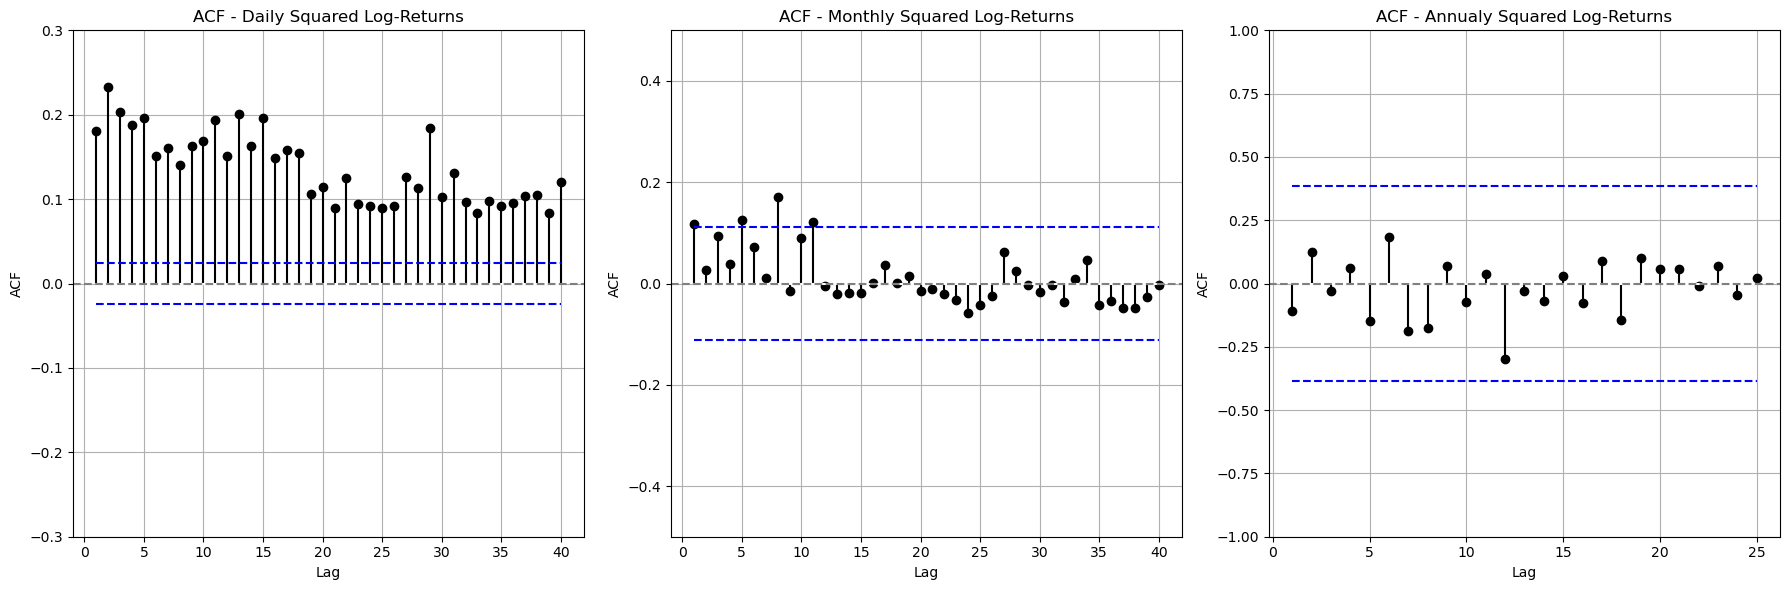

In [32]:
#ACF Daily Squared Log-returns
lags = 40
acf_values_daily = acf(rt_d_all**2, nlags=lags)

confint = 1.96 / np.sqrt(len(rt_d_all))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# ACF log-returns
axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.3, 0.3)
axs[0].set_title('ACF - Daily Squared Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

#ACF Monthly Squared Log-returns
acf_values_monthly = acf(rt_m_all**2, nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_m_all))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)

axs[1].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.5, 0.5)
axs[1].set_title('ACF - Monthly Squared Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)

lags_2=25
#ACF Annualy Squared Log-returns
acf_values_annualy = acf(rt_y_all**2, nlags=lags_2)
confint_annualy = 1.96 / np.sqrt(len(rt_y_all))
confint_annualy_upper = np.full(lags_2, confint_annualy)
confint_annualy_lower = -np.full(lags_2, confint_annualy)

axs[2].stem(np.arange(1, lags_2 + 1), acf_values_annualy[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, lags_2 + 1), confint_annualy_upper, color='blue', linestyle='dashed')
axs[2].plot(np.arange(1, lags_2 + 1), confint_annualy_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-1, 1)
axs[2].set_title('ACF - Annualy Squared Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)

plt.tight_layout()
plt.savefig('Squared_autocorrolation.png', format='png', bbox_inches='tight')
plt.show()

In [33]:
#Daily Squared
my_max_lag = 15
lags_all = np.arange(1, my_max_lag + 1)
my_acf = sm.tsa.acf(rt_d_all**2, nlags=my_max_lag)
my_acf_diameter = 1.96 / np.sqrt(len(rt_d_all))
my_acf_tstat_0 = (my_acf[1:] - 0) / np.sqrt(1 / len(rt_d_all))
my_LjungBox = sm.stats.diagnostic.acorr_ljungbox(rt_d_all**2, lags=lags_all, boxpierce=False)
my_BoxPierce = sm.stats.diagnostic.acorr_ljungbox(rt_d_all**2, lags=lags_all, boxpierce=True)
crit_value_5_BP = stats.chi2.ppf(0.95,lags_all)

my_table = np.column_stack((
    lags_all,
    my_acf[1:],
    np.full(my_max_lag, my_acf_diameter),
    my_acf_tstat_0,
    my_BoxPierce['bp_stat'],
    my_BoxPierce['bp_pvalue'],
    my_LjungBox['lb_stat'],
    my_LjungBox['lb_pvalue'],
    np.full(my_max_lag, crit_value_5_BP)
))
column_names = ["lag", "acf", "acf diam.", "acf test", "B-P stat", "B-P pval", "L-B stat", "L-B pval", "crit"]
my_table_df = pd.DataFrame(data=my_table, columns=column_names)

# Print the rounded table
my_table_df = my_table_df.round(3)
my_table_df

,lag,acf,acf diam.,acf test,B-P stat,B-P pval,L-B stat,L-B pval,crit
0,1.0,0.181,0.024,14.623,213.822,0.0,213.920,0.0,3.841
1,2.0,0.233,0.024,18.837,568.638,0.0,568.953,0.0,5.991
2,3.0,0.203,0.024,16.403,837.699,0.0,838.220,0.0,7.815
3,4.0,0.188,0.024,15.169,1067.792,0.0,1068.524,0.0,9.488
4,5.0,0.196,0.024,15.825,1318.218,0.0,1319.218,0.0,11.070
5,6.0,0.151,0.024,12.219,1467.516,0.0,1468.700,0.0,12.592
6,7.0,0.160,0.024,12.945,1635.088,0.0,1636.502,0.0,14.067
7,8.0,0.140,0.024,11.339,1763.671,0.0,1765.282,0.0,15.507
8,9.0,0.163,0.024,13.150,1936.592,0.0,1938.495,0.0,16.919
9,10.0,0.169,0.024,13.663,2123.280,0.0,2125.525,0.0,18.307


In [34]:
#Realisation of LjungBox and BoxPierce tests with squared returns for different lags
my_max_lag = 100
lags_all = np.arange(1, my_max_lag + 1)

my_acf = sm.tsa.acf(rt_d_all**2, nlags=my_max_lag)
my_acf_diameter = 1.96 / np.sqrt(len(rt_d_all))
my_acf_tstat_0 = (my_acf[1:] - 0) / np.sqrt(1 / len(rt_d_all))
my_LjungBox = sm.stats.diagnostic.acorr_ljungbox(rt_d_all**2, lags=lags_all, boxpierce=False)
my_BoxPierce = sm.stats.diagnostic.acorr_ljungbox(rt_d_all**2, lags=lags_all, boxpierce=True)
crit_value_5_BP = stats.chi2.ppf(0.95, lags_all)

my_table = np.column_stack((
    lags_all,
    my_acf[1:],
    np.full(my_max_lag, my_acf_diameter),
    my_acf_tstat_0,
    my_BoxPierce['bp_stat'],
    my_BoxPierce['bp_pvalue'],
    my_LjungBox['lb_stat'],
    my_LjungBox['lb_pvalue'],
    crit_value_5_BP
))

column_names = ["lag", "acf", "acf diam.", "acf test", "B-P stat", "B-P pval", "L-B stat", "L-B pval", "crit"]
my_table_df = pd.DataFrame(data=my_table, columns=column_names)

lags_to_display = [5, 20, 100]
lags_to_display = [lag for lag in lags_to_display if lag <= my_max_lag]  # sécurité

my_table_filtered2 = my_table_df[my_table_df["lag"].isin(lags_to_display)]

my_table_filtered2 = my_table_filtered2.round(3)
my_table_filtered2

,lag,acf,acf diam.,acf test,B-P stat,B-P pval,L-B stat,L-B pval,crit
4,5.0,0.196,0.024,15.825,1318.218,0.0,1319.218,0.0,11.070
19,20.0,0.115,0.024,9.273,3832.496,0.0,3839.123,0.0,31.410
99,100.0,0.056,0.024,4.494,6981.990,0.0,7012.298,0.0,124.342


In [35]:
my_table_filtered2.to_latex("my_table_lags2.tex", index=False, float_format="%.3f")

==== ARCH TEST ====
Statistic: 36.8934
P-value: 0.0002
H0 rejected → ARCH effect detected (heteroscedastic variance)


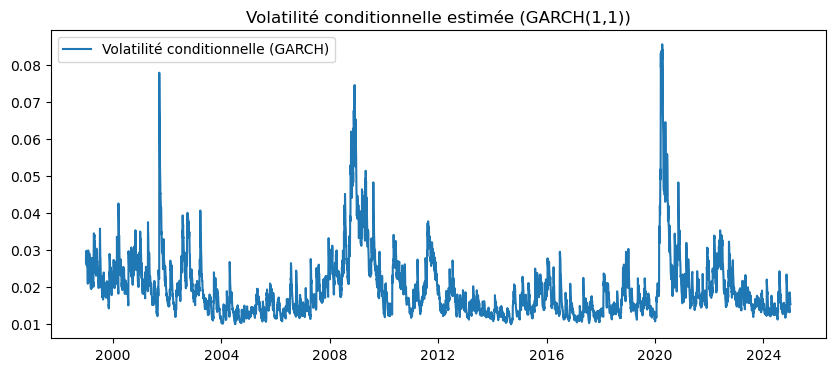


==== HURST EXPONENT ====
Hurst exponent: 0.853
Constant c: 1.100
The series exhibits long-term dependency (long memory).


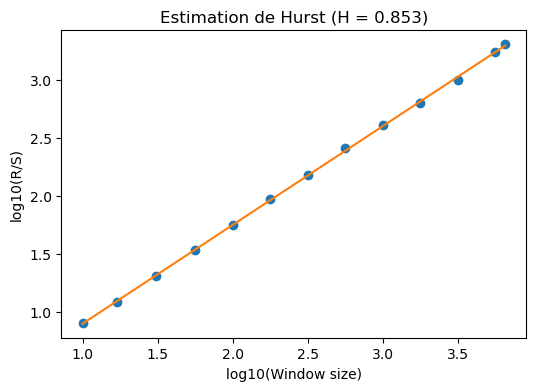

In [36]:
squared_returns = rt_d_all ** 2

arch_test = het_arch(squared_returns, nlags=12)
arch_stat, arch_pval = arch_test[0], arch_test[1]

print("==== ARCH TEST ====")
print(f"Statistic: {arch_stat:.4f}")
print(f"P-value: {arch_pval:.4f}")
if arch_pval < 0.05:
    print("H0 rejected → ARCH effect detected (heteroscedastic variance)")
else:
    print("H0 non rejected → Not ARCH effect detected")

#plot ARCH effect

model = arch_model(rt_d_all, vol='GARCH', p=1, q=1, rescale=False)
res = model.fit(disp='off')

plt.figure(figsize=(10, 4))
plt.plot(res.conditional_volatility, label='Volatilité conditionnelle (GARCH)')
plt.title("Volatilité conditionnelle estimée (GARCH(1,1))")
plt.legend()
plt.show()

#Hurst

H, c, data = compute_Hc(squared_returns, kind='change', simplified=True)

print("\n==== HURST EXPONENT ====")
print(f"Hurst exponent: {H:.3f}")
print(f"Constant c: {c:.3f}")

if H > 0.5:
    print("The series exhibits long-term dependency (long memory).")
elif H < 0.5:
    print("The series is anti-persistent (return to the mean).")
else:
    print("The series is close to a random walk process.")

plt.figure(figsize=(6, 4))
plt.plot(np.log10(data[0]), np.log10(data[1]), 'o')
plt.plot(np.log10(data[0]), H * np.log10(data[0]) + np.log10(c))
plt.title(f"Estimation de Hurst (H = {H:.3f})")
plt.xlabel("log10(Window size)")
plt.ylabel("log10(R/S)")
plt.show()

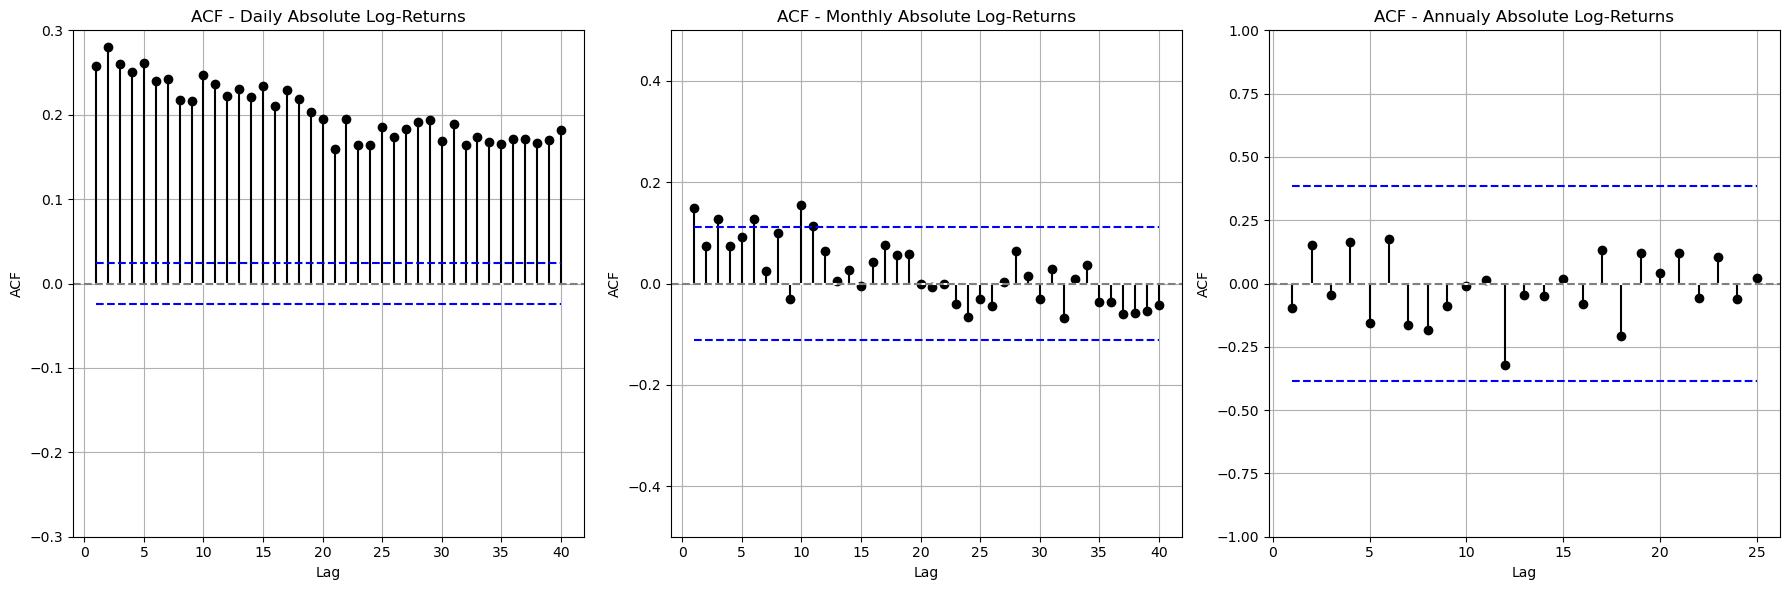

In [37]:
#ACF Daily Absolute Log-returns
lags = 40
acf_values_daily = acf(abs(rt_d_all), nlags=lags)

confint = 1.96 / np.sqrt(len(rt_d_all))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.3, 0.3)
axs[0].set_title('ACF - Daily Absolute Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

#ACF Monthly Absolute Log-returns
acf_values_monthly = acf(abs(rt_m_all), nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_m_all))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)

axs[1].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.5, 0.5)
axs[1].set_title('ACF - Monthly Absolute Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)

lags_2=25
#ACF Monthly Absolute Log-returns
acf_values_annualy = acf(abs(rt_y_all), nlags=lags_2)
confint_annualy = 1.96 / np.sqrt(len(rt_y_all))
confint_annualy_upper = np.full(lags_2, confint_annualy)
confint_annualy_lower = -np.full(lags_2, confint_annualy)

axs[2].stem(np.arange(1, lags_2 + 1), acf_values_annualy[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, lags_2 + 1), confint_annualy_upper, color='blue', linestyle='dashed')
axs[2].plot(np.arange(1, lags_2 + 1), confint_annualy_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-1, 1)
axs[2].set_title('ACF - Annualy Absolute Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [38]:
#Daily Absolute
my_max_lag = 15
lags_all = np.arange(1, my_max_lag + 1)
my_acf = sm.tsa.acf(abs(rt_d_all), nlags=my_max_lag)
my_acf_diameter = 1.96 / np.sqrt(len(rt_d_all))
my_acf_tstat_0 = (my_acf[1:] - 0) / np.sqrt(1 / len(rt_d_all))
my_LjungBox = sm.stats.diagnostic.acorr_ljungbox(abs(rt_d_all), lags=lags_all, boxpierce=False)
my_BoxPierce = sm.stats.diagnostic.acorr_ljungbox(abs(rt_d_all), lags=lags_all, boxpierce=True)
crit_value_5_BP = stats.chi2.ppf(0.95,lags_all)

my_table = np.column_stack((
    lags_all,
    my_acf[1:],
    np.full(my_max_lag, my_acf_diameter),
    my_acf_tstat_0,
    my_BoxPierce['bp_stat'],
    my_BoxPierce['bp_pvalue'],
    my_LjungBox['lb_stat'],
    my_LjungBox['lb_pvalue'],
    np.full(my_max_lag, crit_value_5_BP)
))
column_names = ["lag", "acf", "acf diam.", "acf test", "B-P stat", "B-P pval", "L-B stat", "L-B pval", "crit"]
my_table_df = pd.DataFrame(data=my_table, columns=column_names)

# Print the rounded table
my_table_df = my_table_df.round(3)
my_table_df

,lag,acf,acf diam.,acf test,B-P stat,B-P pval,L-B stat,L-B pval,crit
0,1.0,0.258,0.024,20.846,434.573,0.0,434.772,0.0,3.841
1,2.0,0.280,0.024,22.663,948.191,0.0,948.705,0.0,5.991
2,3.0,0.260,0.024,20.993,1388.886,0.0,1389.737,0.0,7.815
3,4.0,0.250,0.024,20.256,1799.207,0.0,1800.434,0.0,9.488
4,5.0,0.261,0.024,21.124,2245.423,0.0,2247.128,0.0,11.070
5,6.0,0.240,0.024,19.437,2623.236,0.0,2625.404,0.0,12.592
6,7.0,0.242,0.024,19.598,3007.305,0.0,3010.002,0.0,14.067
7,8.0,0.217,0.024,17.580,3316.352,0.0,3319.522,0.0,15.507
8,9.0,0.216,0.024,17.458,3621.147,0.0,3624.830,0.0,16.919
9,10.0,0.247,0.024,19.940,4018.762,0.0,4023.176,0.0,18.307


C:\Users\cleme\AppData\Local\Temp\ipykernel_19556\2223824075.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = rt_d_all[est_window]
C:\Users\cleme\AppData\Local\Temp\ipykernel_19556\2223824075.py:23: RuntimeWarning: divide by zero encountered in divide
  sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
C:\Users\cleme\AppData\Local\Temp\ipykernel_19556\2223824075.py:23: RuntimeWarning: invalid value encountered in multiply
  sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
C:\Users\cleme\AppData\Local\Temp\ipykernel_19556\2223824075.py:24: RuntimeWarning: divide by zero encountered in divide
  sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_lengt

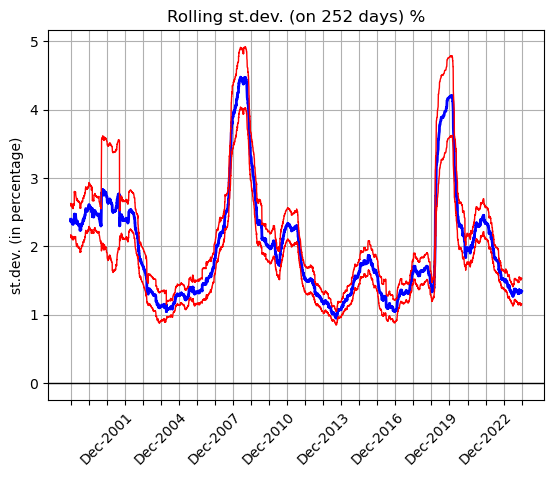

In [39]:
# set the rolling window equal to 252 days
window_length = 252
T = rt_d_all.shape[0]

# Create an empty matrix to store data
roll_mom_manual = np.zeros((T, 5))

# Run a for loop to fill the matrix with moments
for i in range(window_length, T):
    est_window = np.arange(i - window_length + 1, i + 1)
    y = rt_d_all[est_window]
    
    # compute the moments for each 
    roll_mom_manual[i, 0] = np.mean(y)
    roll_mom_manual[i, 1] = np.std(y, ddof=1)
    roll_mom_manual[i, 2] = skew(y)
    roll_mom_manual[i, 3] = kurtosis(y)
    roll_mom_manual[i, 4] = np.mean((y - np.mean(y))**4)

# extract the Std Dev from roll_mom_manual
sd_plot = roll_mom_manual[:,1]
mu4 = roll_mom_manual[:,4]
sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)

data2plot_na = np.column_stack((sd_plot, sd_plot_lb, sd_plot_ub))
data_index = rt_d_all.index
data2plot_na = pd.DataFrame({'StD': sd_plot, 'LowerBound': sd_plot_lb, 'UpperBound': sd_plot_ub},
                               index=data_index)

# Select only rows without missing values
data2plot = data2plot_na.dropna()
# retrieve the data index
data2plot

# Customizing x-axis labels for December 31 of each year
date_labels = pd.date_range(start='1999-01-01', end='2024-12-31', freq='YE-DEC')
# Show 1 tick every 3 years
formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
# Add labels and rotate them 
plt.xticks(date_labels, formatted_labels, rotation=45)

# Plot the data
plt.plot(data2plot.index, data2plot["StD"] * 100, color='blue', linestyle='-', linewidth=2)
plt.plot(data2plot.index, data2plot["LowerBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.plot(data2plot.index, data2plot["UpperBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.xlabel('')
plt.grid(True)
plt.ylabel('st.dev. (in percentage)')
plt.title('Rolling st.dev. (on 252 days) %')
plt.axhline(0, linestyle='-', color='black', linewidth=1)  # Add a zero line

plt.savefig('Standard_deviation.png', format='png', bbox_inches='tight')
plt.show()

### Stylized fact 8: Leverage effect

In [41]:
# define a function
def ccf(x, y, lag_max = 100):
    # compute correlation
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    # define the length
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

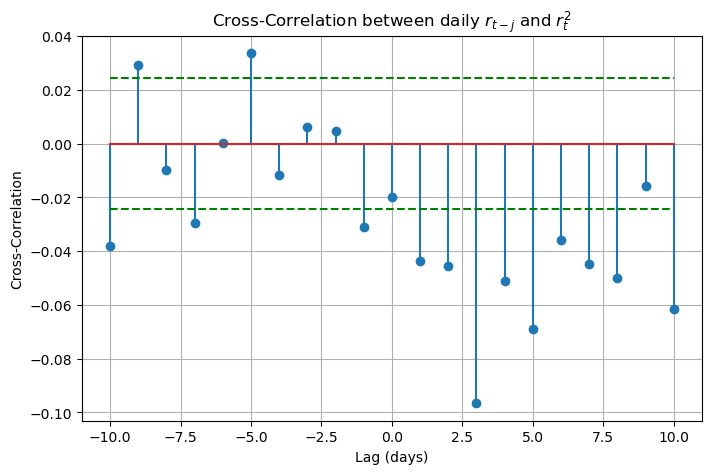

In [42]:
# choose the max lag and execute the function
lag_max = 10
cross_corr = ccf(rt_d_all,rt_d_all**2,lag_max=lag_max)

# plot results
lags = np.arange(-lag_max, lag_max + 1)

# ACF dei log-returns mensili con bande di confidenza
confint_daily = 1.96 / np.sqrt(len(rt_d_all))
confint_daily_upper = np.full(len(lags), confint_daily)
confint_daily_lower = -np.full(len(lags), confint_daily)

plt.figure(figsize=(8, 5))
plt.stem(lags, cross_corr)
plt.plot(lags, confint_daily_upper, color='green', linestyle='dashed')
plt.plot(lags, confint_daily_lower, color='green', linestyle='dashed')
plt.xlabel('Lag (days)')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between daily $r_{t-j}$ and $r_t^2$')
plt.grid(True)

plt.savefig('Cross_correlation.png', format='png', bbox_inches='tight')
plt.show()

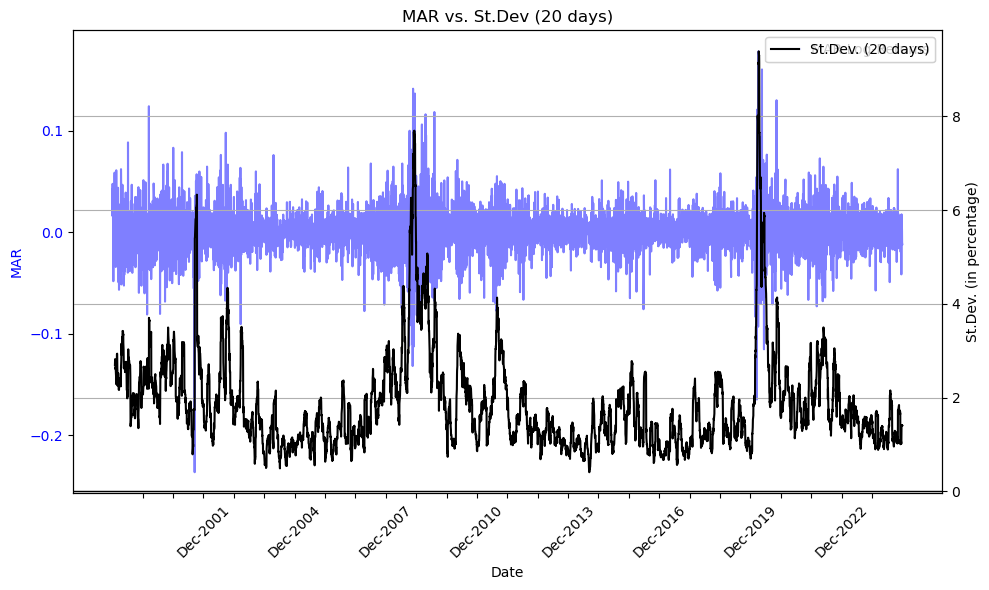

In [43]:
def calculate_rolling_moments(returns, window_length):
    """
    Calculates rolling mean and standard deviation (StD) using the manual loop method.
    Returns two DataFrames: one for Mean and one for StD.
    """
    T_local = returns.shape[0]
    # Initialize the matrix where results will be stored. Columns 0 and 1 are Mean and StD.
    roll_mom_manual = np.zeros((T_local, 2)) 
    
    # Run loop from the end of the first window onwards
    for i in range(window_length, T_local):
        # Define the estimation window
        est_window = np.arange(i - window_length, i)
        y = returns.iloc[est_window]
        
        # Compute the moments
        roll_mom_manual[i, 0] = np.std(y, ddof=1) # StD (S)
        roll_mom_manual[i, 1] = np.mean((y - np.mean(y))**4) # Mu4 (M4)
    
    # Extract moments
    sd_plot = roll_mom_manual[:, 0]
    mu4 = roll_mom_manual[:, 1]
    
    # Handling zeros/NaNs to avoid RuntimeWarnings during division in bound calculation
    sd_plot_safe = np.where(sd_plot == 0, np.nan, sd_plot)

    # --- Calculate Mean and StD Series (No Bounds needed as per simplest request) ---
    
    # StD Bounds: S +/- 1.96 * (Std Error of StD)
    term_std_error = (1 / (2 * sd_plot_safe) * np.sqrt(mu4 - sd_plot_safe**4)) / np.sqrt(window_length)
    sd_ub = sd_plot + 1.96 * term_std_error
    sd_lb = sd_plot - 1.96 * term_std_error
    
    # Create DataFrames containing only the core moment (Mean or StD)
    data_index = returns.index
    df_std = pd.DataFrame({'StD': sd_plot, 'LowerBound': sd_lb, 'UpperBound': sd_ub}, index=data_index).dropna()
    
    return df_std

window_length = 20  # Short-term/VIX proxy
df_std_20 = calculate_rolling_moments(rt_d_all, window_length)

# define the figure parameters
fig, ax1 = plt.subplots(figsize=(10, 6))

# Adjust x-axis labels (using the most complete index)
start_date = df_std_20.index.min()
end_date = df_std_20.index.max()
date_labels = pd.date_range(start=start_date, end=end_date, freq='YE')
formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
plt.xticks(date_labels, formatted_labels, rotation=45)

ax1.plot(rt_d_all.index, rt_d_all, color='blue', label='MAR Log-Returns', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('MAR', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()

# --- GRAPH 2: ROLLING STANDARD DEVIATION (VOLATILITY) ---
ax2 = ax1.twinx()
ax2.plot(df_std_20.index, df_std_20["StD"] * 100, color='black', linewidth=1.5, label=f'St.Dev. ({window_length} days)')
ax2.set_ylabel('St.Dev. (in percentage)', color = 'black')
ax2.set_xlabel('Date')
ax2.axhline(0, linestyle='-', color='black', linewidth=1)
ax2.set_xticks(date_labels)
ax2.set_xticklabels(formatted_labels, rotation=45, ha='right')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

plt.title('MAR vs. St.Dev (20 days)')
plt.grid(True)
plt.tight_layout()
plt.show()

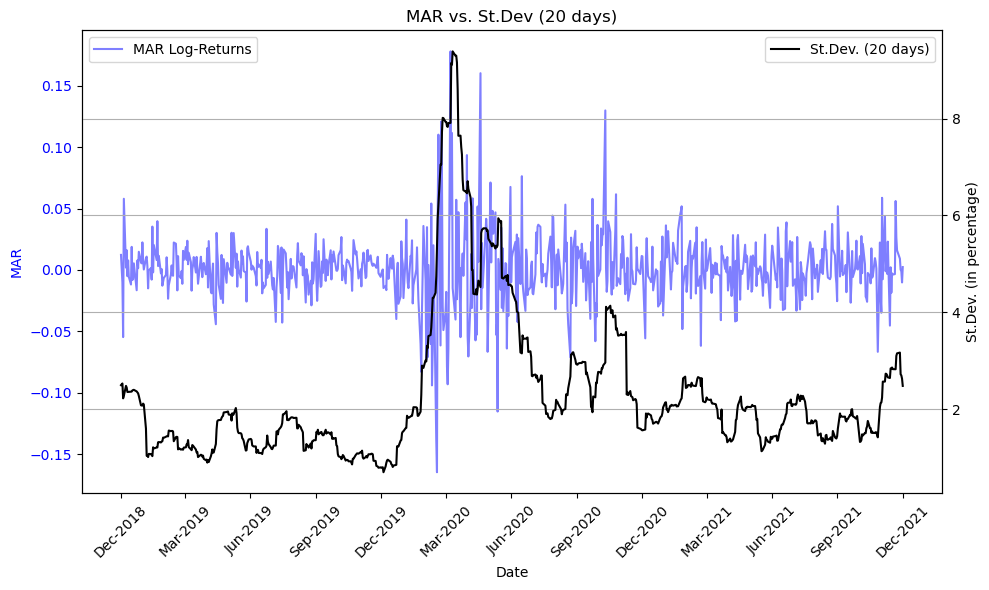

In [44]:
#zoom on log returns (2019-2021)
def calculate_rolling_moments(returns, window_length):
    """
    Calculates rolling mean and standard deviation (StD) using the manual loop method.
    Returns two DataFrames: one for Mean and one for StD.
    """
    T_local = returns.shape[0]
    # Initialize the matrix where results will be stored. Columns 0 and 1 are Mean and StD.
    roll_mom_manual = np.zeros((T_local, 2)) 
    
    # Run loop from the end of the first window onwards
    for i in range(window_length, T_local):
        # Define the estimation window
        est_window = np.arange(i - window_length, i)
        y = returns.iloc[est_window]
        
        # Compute the moments
        roll_mom_manual[i, 0] = np.std(y, ddof=1) # StD (S)
        roll_mom_manual[i, 1] = np.mean((y - np.mean(y))**4) # Mu4 (M4)
    
    # Extract moments
    sd_plot = roll_mom_manual[:, 0]
    mu4 = roll_mom_manual[:, 1]
    
    # Handling zeros/NaNs to avoid RuntimeWarnings during division in bound calculation
    sd_plot_safe = np.where(sd_plot == 0, np.nan, sd_plot)

    # --- Calculate Mean and StD Series (No Bounds needed as per simplest request) ---
    
    # StD Bounds: S +/- 1.96 * (Std Error of StD)
    term_std_error = (1 / (2 * sd_plot_safe) * np.sqrt(mu4 - sd_plot_safe**4)) / np.sqrt(window_length)
    sd_ub = sd_plot + 1.96 * term_std_error
    sd_lb = sd_plot - 1.96 * term_std_error
    
    # Create DataFrames containing only the core moment (Mean or StD)
    data_index = returns.index
    df_std = pd.DataFrame({'StD': sd_plot, 'LowerBound': sd_lb, 'UpperBound': sd_ub}, index=data_index).dropna()
    
    return df_std

window_length = 20  # Short-term/VIX proxy
df_std_20 = calculate_rolling_moments(rt_d_all, window_length)

# define the figure parameters
fig, ax1 = plt.subplots(figsize=(10, 6))

# Adjust x-axis labels (using the most complete index)
start_date = "2018-12-31"
end_date = "2021-12-31"
date_labels = pd.date_range(start=start_date, end=end_date, freq='3ME')
formatted_labels = [date.strftime('%b-%Y') for date in date_labels]
plt.xticks(date_labels, formatted_labels, rotation=45)

rt_d_zoom = rt_d_all.loc[start_date:end_date]
df_std_20_zoom = df_std_20.loc[start_date:end_date]

ax1.plot(rt_d_zoom.index, rt_d_zoom, color='blue', label='MAR Log-Returns',alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('MAR', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# --- GRAPH 2: ROLLING STANDARD DEVIATION (VOLATILITY) ---
ax2 = ax1.twinx()
ax2.plot(df_std_20_zoom.index, df_std_20_zoom["StD"] * 100, color='black', linewidth=1.5, label=f'St.Dev. ({window_length} days)')
ax2.set_ylabel('St.Dev. (in percentage)', color = 'black')
ax2.set_xlabel('Date')
ax2.set_xticks(date_labels)
ax2.set_xticklabels(formatted_labels, rotation=45, ha='right')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend()

plt.title('MAR vs. St.Dev (20 days)')
plt.grid(True)
plt.tight_layout()
plt.savefig('MARvsSt.Dev.png', format='png', bbox_inches='tight')
plt.show()

C:\Users\cleme\AppData\Local\Temp\ipykernel_19556\1939799320.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VIX = yf.download("^VIX", start="2018-12-31" ,end="2021-12-31")
[*********************100%***********************]  1 of 1 completed


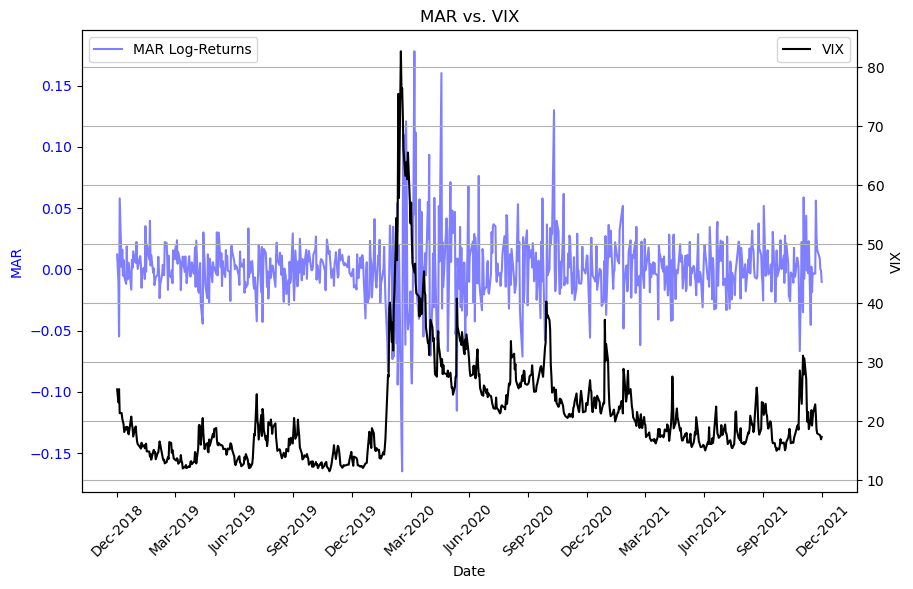

In [45]:
# get S&P and VIX data
VIX = yf.download("^VIX", start="2018-12-31" ,end="2021-12-31")

# extract the adjusted closing prices
VIX_d = VIX["Close"]

# rename the columns
VIX_d = VIX_d.rename(columns={VIX_d.columns[0]: "VIX.d"})

# mutate the Index into a DatetimeIndex
VIX_d.index = pd.to_datetime(VIX_d.index)  

# merge the two datasets and rename columns
merged_df = pd.merge(rt_d_all, VIX_d, on='Date', how='outer') # outer: only commond indexes (dates)
merged_df.head()

# Compute changes in pt and VIX compared to previous period (NaN are kept)
diff_df = merged_df.diff()
diff_df.head()

# remove from the price dataframe
merged_df = merged_df.dropna()
# and from the second one
diff_df = diff_df.dropna()

# define the figure parameters
fig, ax1 = plt.subplots(figsize=(10, 6))

# Customizing x-axis labels for December of each year
date_labels = pd.date_range(start=start_date, end=end_date, freq='3ME')
formatted_labels = [date.strftime('%b-%Y') for date in date_labels]
# Add label and rotate them
plt.xticks(date_labels, formatted_labels, rotation=45)

# work on the first y-axis
ax1.plot(merged_df.index, merged_df['rt.d.all'], label='MAR Log-Returns', color='blue', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('MAR', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# work on the second y-axis: VIX
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['VIX.d'], label='VIX', color='black')
ax2.set_ylabel('VIX', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend()

plt.title('MAR vs. VIX')
plt.grid(True)
plt.show()

# Exercice 2

In [47]:
#Fama French Factor
FF_factors_m = pd.read_csv("C:\\Users\\cleme\\Financial econometrics with Python\\Projet\\F-F_Research_Data_Factors.csv", sep=",", skiprows=4, header=0, parse_dates=[0], index_col=0)
FF_factors_m = FF_factors_m.loc["199901":"202412"]
FF_factors_m.index = pd.to_datetime(FF_factors_m.index.astype(str) + '01') + pd.offsets.MonthEnd(0)

FF_factors_m["Mkt-RF"] = FF_factors_m["Mkt-RF"] + FF_factors_m["RF"];
FF_factors_m = FF_factors_m.rename(columns={"Mkt-RF": "CRSP_VW"})
ffm_m = FF_factors_m.iloc[:, 0:3]  # 3 Fama-French factors (daily frequency)
rf_m = FF_factors_m.iloc[:, 3].to_frame()  # monthly risk-free rate (daily 1 month Tbill), 4th column

# DOWNLOAD DATA
date_start = "1998-12-31"
date_end = "2024-12-31"
# S&P500
sp500_all = yf.download('^GSPC', start=date_start, end=date_end)
sp500_ad = sp500_all["Close"]
sp500_ad = sp500_ad.rename(columns={sp500_ad.columns[0]: "Close"})
sp500_ad = sp500_ad.resample('ME').last()

#Prices
prices_m = sp500_ad.merge(Pt_m_all, on='Date', how='inner')
prices_m = prices_m.rename(columns={'Close': 'sp500', 'Daily Close': 'MAR'})

C:\Users\cleme\AppData\Local\Temp\ipykernel_19556\3183448713.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  FF_factors_m = pd.read_csv("C:\\Users\\cleme\\Financial econometrics with Python\\Projet\\F-F_Research_Data_Factors.csv", sep=",", skiprows=4, header=0, parse_dates=[0], index_col=0)
C:\Users\cleme\AppData\Local\Temp\ipykernel_19556\3183448713.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  FF_factors_m = pd.read_csv("C:\\Users\\cleme\\Financial econometrics with Python\\Projet\\F-F_Research_Data_Factors.csv", sep=",", skiprows=4, header=0, parse_dates=[0], index_col=0)
C:\Users\cleme\AppData\Local\Temp\ipykernel_19556\3183448713.py:15: FutureWarning: YF.download() has changed argument auto_adjus

In [48]:
#Simple returns
rt_m = prices_m.pct_change()
rt_m = rt_m.dropna()
rt_m = pd.DataFrame(rt_m)
rt_m = rt_m*100

# merge columns of simple returns with FF Factors returns
ret_m_all = ffm_m.join(rt_m, how='inner').join(rf_m, how='inner')

# computes excess returns 
z_m_all = ret_m_all.drop(["RF"], axis=1)

col_ret = [0, 3, 4]

for col in col_ret:
    z_m_all.iloc[:, col] = ret_m_all.iloc[:, col] - ret_m_all.iloc[:, 5]    
z_m_all

,CRSP_VW,SMB,HML,sp500,MAR
1999-01-31,3.48,0.67,-4.46,3.750944,20.770653
1999-02-28,-4.08,-6.02,1.95,-3.578256,2.141103
1999-03-31,3.48,-3.84,-2.61,3.449422,-7.027234
1999-04-30,4.34,3.89,2.40,3.424403,24.350742
1999-05-31,-2.46,3.32,2.49,-2.837048,-9.444438
...,...,...,...,...,...
2024-08-31,1.60,-3.49,-1.10,1.803471,3.065183
2024-09-30,1.72,-0.13,-2.77,1.619688,5.526965
2024-10-31,-1.00,-0.99,0.86,-1.379674,4.203708
2024-11-30,6.49,4.46,0.15,5.330130,11.030479


In [49]:
# Dataframe
ret_m_df = pd.DataFrame({'date': ret_m_all.index, 'MKT': ret_m_all['CRSP_VW'], 'SMB': ret_m_all['SMB'],
                         'HML': ret_m_all['HML'], 'S&P500': ret_m_all['sp500'], 'MAR': ret_m_all['MAR'], 'rf': ret_m_all['RF']})
z_m_df = pd.DataFrame({'date': z_m_all.index, 'MKT': z_m_all['CRSP_VW'], 'SMB': z_m_all['SMB'],
                       'HML': z_m_all['HML'], 'S&P500': z_m_all['sp500'],'MAR': z_m_all['MAR']})
z_m_df

,date,MKT,SMB,HML,S&P500,MAR
1999-01-31,1999-01-31,3.48,0.67,-4.46,3.750944,20.770653
1999-02-28,1999-02-28,-4.08,-6.02,1.95,-3.578256,2.141103
1999-03-31,1999-03-31,3.48,-3.84,-2.61,3.449422,-7.027234
1999-04-30,1999-04-30,4.34,3.89,2.40,3.424403,24.350742
1999-05-31,1999-05-31,-2.46,3.32,2.49,-2.837048,-9.444438
...,...,...,...,...,...,...
2024-08-31,2024-08-31,1.60,-3.49,-1.10,1.803471,3.065183
2024-09-30,2024-09-30,1.72,-0.13,-2.77,1.619688,5.526965
2024-10-31,2024-10-31,-1.00,-0.99,0.86,-1.379674,4.203708
2024-11-30,2024-11-30,6.49,4.46,0.15,5.330130,11.030479


### Tracés intermédiaires

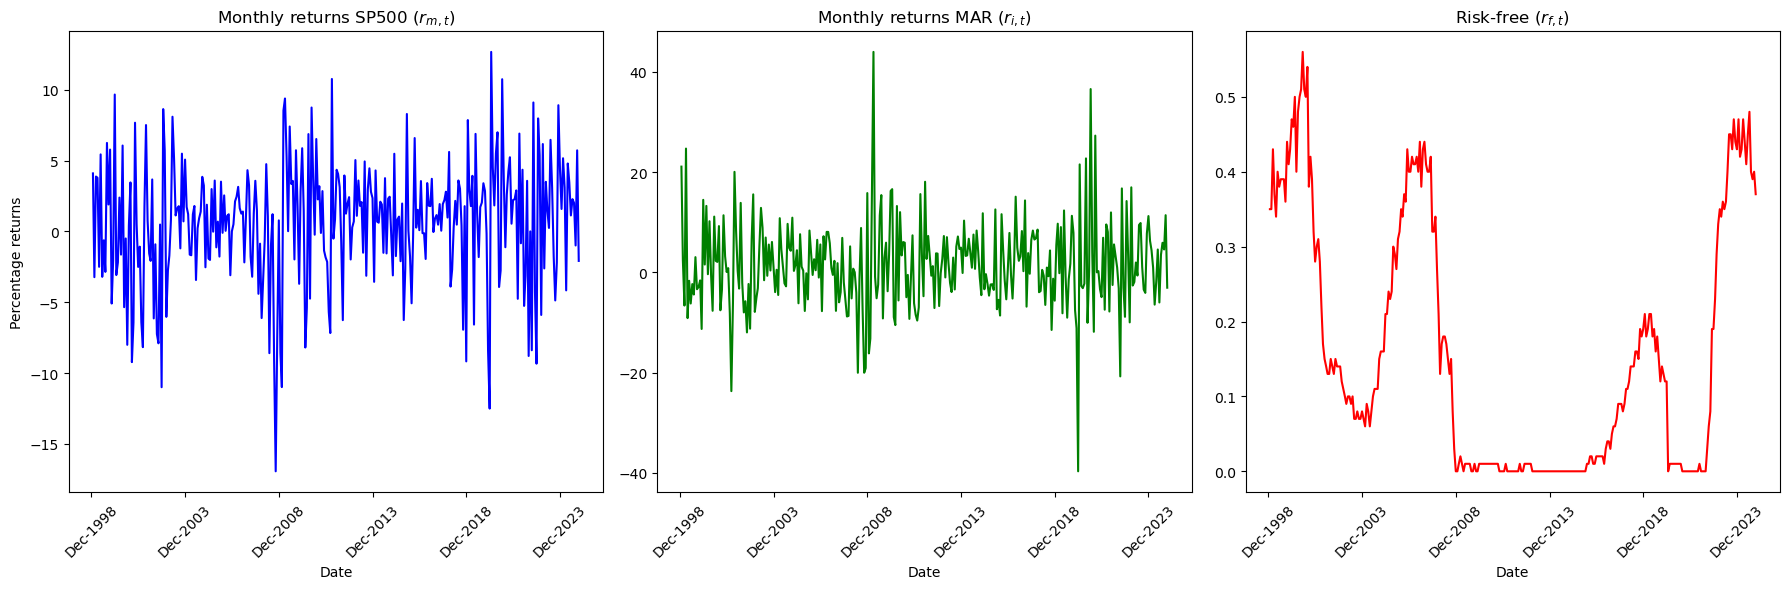

In [51]:
d2plot = ret_m_df
date_labels = pd.date_range(start="1998-12-31" ,end="2024-12-31", freq='5YE-DEC')
formatted_labels = [f'Dec-{date.year}' for date in date_labels]

# define a 1x3 grid for the 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# SP500
axs[0].plot(d2plot['date'], d2plot['S&P500'], linestyle='-', marker='', color='blue')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Percentage returns')
axs[0].set_title('Monthly returns SP500 ($r_{m,t}$)')
axs[0].set_xticks(date_labels, formatted_labels, rotation=45)

# MAR
axs[1].plot(d2plot['date'], d2plot['MAR'], linestyle='-', marker='', color='green')
axs[1].set_xlabel('Date')
axs[1].set_title('Monthly returns MAR ($r_{i,t}$)')
axs[1].set_xticks(date_labels, formatted_labels, rotation=45)

# r-f
axs[2].plot(d2plot['date'], d2plot['rf'], linestyle='-', marker='', color='red')
axs[2].set_xlabel('Date')
axs[2].set_title('Risk-free ($r_{f,t}$)')
axs[2].set_xticks(date_labels, formatted_labels, rotation=45)

plt.tight_layout()
plt.show()

### CAPM with S&P500

In [53]:
# CAPM where market is S&P 500, monthly data
y = z_m_df.iloc[:, 5]  
# Sp500 monthly excess ret
x1_SP500 = z_m_df.iloc[:, 4]  
### Linear Regression
X_CAPM_SP500 = sm.add_constant(x1_SP500)  
reg1 = sm.OLS(y, X_CAPM_SP500).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MAR   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     275.5
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           1.02e-44
Time:                        01:31:45   Log-Likelihood:                -1021.3
No. Observations:                 312   AIC:                             2047.
Df Residuals:                     310   BIC:                             2054.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6673      0.365      1.830      0.068      -0.050       1.385
S&P500         1.3705      0.083     16.599      0.000       1.208       1.533
==============================================================================
Omnibus:                       38.622   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.987
Skew:                           0.627   Prob(JB):                     2.13e-19
Kurtosis:                       5.245   Cond. No.                         4.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
#Regression result with CAPM S&P
alpha = reg1.params['const']
beta = reg1.params['S&P500']

print("--- CAPM Results---")
print(f"Alpha (daily): {alpha:.6f}")
print(f"Beta: {beta:.4f}")

--- CAPM Results---
Alpha (daily): 0.667304
Beta: 1.3705


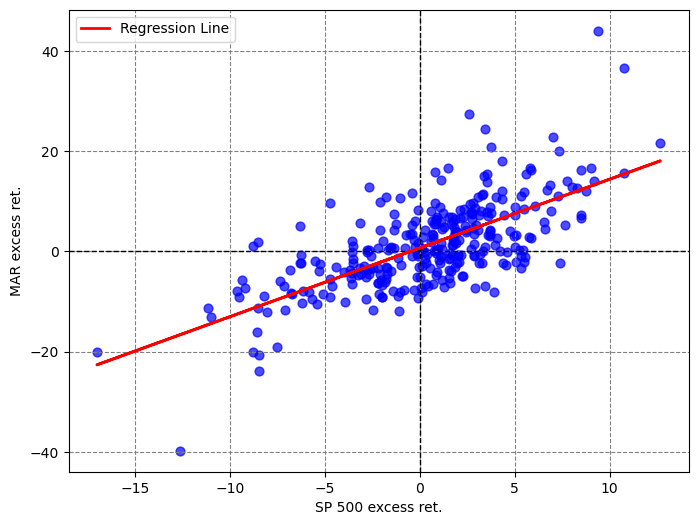

<Figure size 640x480 with 0 Axes>

In [55]:
# represent the predicted values through an histogram
plt.figure(figsize=(8, 6))
plt.scatter(x1_SP500, y, color="blue", s=40, alpha=0.7)
plt.xlabel("SP 500 excess ret.")
plt.ylabel("MAR excess ret.")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(linestyle="--", color="grey")

# Compute the predicted values
y_pred_1 = reg1.predict(X_CAPM_SP500)

# Draw the regression line in red
plt.plot(x1_SP500, y_pred_1, color="red", linewidth=2, label="Regression Line")
plt.legend()
plt.show()
plt.savefig('CAPM_SP500.png', format='png', bbox_inches='tight')

In [56]:
# Perform White's test
white_test_1 = het_white(reg1.resid,  reg1.model.exog)

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test_1)))

{'Test Statistic': 17.74149462257079, 'Test Statistic p-value': 0.0001404375978475213, 'F-Statistic': 9.315145931538606, 'F-Test p-value': 0.00011796401504026581}


### CAPM with Market

In [58]:
# CAPM where market is the fama french factor, monthly data
# MAR monthly excess ret
y = z_m_df.iloc[:, 5]  
# Market monthly excess ret
x1_mkt = z_m_df.iloc[:, 1]  
### Linear Regression
X_CAPM_MKT = sm.add_constant(x1_mkt)  
reg2 = sm.OLS(y, X_CAPM_MKT).fit()
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MAR   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     264.1
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           2.20e-43
Time:                        01:31:46   Log-Likelihood:                -1024.4
No. Observations:                 312   AIC:                             2053.
Df Residuals:                     310   BIC:                             2060.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4502      0.370      1.217      0.225      -0.278       1.178
MKT            1.3081      0.080     16.251      0.000       1.150       1.466
==============================================================================
Omnibus:                       35.533   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.370
Skew:                           0.590   Prob(JB):                     2.61e-17
Kurtosis:                       5.117   Cond. No.                         4.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
#Regression result with CAPM Market
alpha_mkt = reg2.params['const']
beta_mkt = reg2.params['MKT']

print("--- CAPM Results ---")
print(f"Alpha (daily): {alpha_mkt:.6f}")
print(f"Beta: {beta_mkt:.4f}")

--- CAPM Results ---
Alpha (daily): 0.450211
Beta: 1.3081


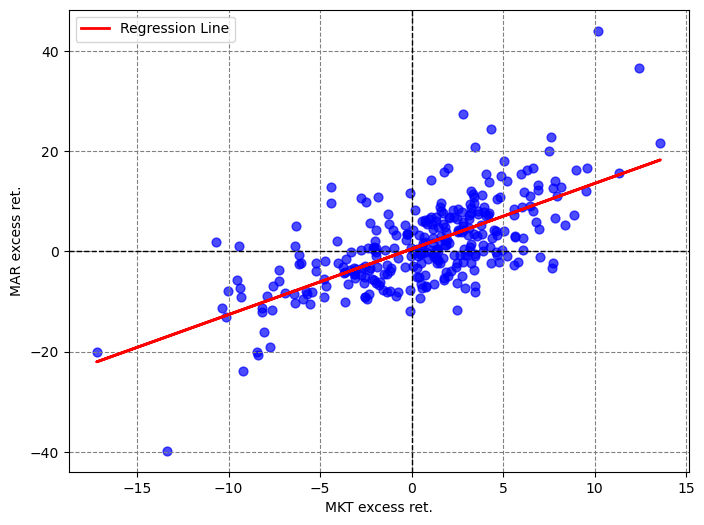

In [60]:
# represent the predicted values through an histogram
plt.figure(figsize=(8, 6))
plt.scatter(x1_mkt, y, color="blue", s=40, alpha=0.7)
plt.xlabel("MKT excess ret.")
plt.ylabel("MAR excess ret.")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.grid(linestyle="--", color="grey")

# Compute the predicted values
y_pred_2 = reg2.predict(X_CAPM_MKT)

# Draw the regression line in red
plt.plot(x1_mkt, y_pred_2, color="red", linewidth=2, label="Regression Line")
plt.legend()
plt.savefig('CAPM_MKT.png', format='png', bbox_inches='tight')
plt.show()

In [61]:
# Perform White's test
white_test_2 = het_white(reg2.resid,  reg2.model.exog)

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test_2)))

{'Test Statistic': 23.71387532216185, 'Test Statistic p-value': 7.089202819265522e-06, 'F-Statistic': 12.708879906614726, 'F-Test p-value': 4.964586412489916e-06}


In [62]:
residuals_2 = reg2.resid
residuals_squared_2 = residuals_2 ** 2

all_data_2 = pd.DataFrame({
    'res': residuals_2,
    'res_squared': residuals_squared_2
})

stat_table_2 = pd.DataFrame({col: multi_fun(all_data_2[col]) for col in all_data_2.columns})

stat_table_2 = stat_table_2.round(3)
stat_table_2

,res,res_squared
Mean,-0.000,4163.259
St.Deviation,645.233,8447.548
Diameter.C.I.Mean,71.597,937.367
Skewness,0.590,5.538
Kurtosis,5.117,46.092
Excess.Kurtosis,2.117,43.092
Min,-2275.010,0.131
Quant5,-950.520,7.419
Quant25,-412.152,332.385
Median,-27.083,1383.688


In [63]:
jb_statistic, jb_p_value = stats.jarque_bera(residuals_2)
print("Jarque-Bera Test on Residuals:")
print("JB Statistic:", jb_statistic)
print("p-value:", jb_p_value)

jb_statistic, jb_p_value = stats.jarque_bera(residuals_squared_2)
print("Jarque-Bera Test on Residuals^2:")
print("JB Statistic:", jb_statistic)
print("p-value:", jb_p_value)

Jarque-Bera Test on Residuals:
JB Statistic: 76.36961424390408
p-value: 2.609449968132726e-17
Jarque-Bera Test on Residuals^2:
JB Statistic: 25734.11945134479
p-value: 0.0


# 3 Factors model of Fama and French

In [65]:
### Run the FF 3 factors regression 

# Extract data columns
MAR = z_m_df['MAR']  # MAR
MKT = z_m_df['MKT']  # CRSP VW
SMB = z_m_df['SMB']  # SMB
HML = z_m_df['HML']  # HML

# define a vector of ones
ones_v = np.ones((len(MAR), 1))  
# build the matrix X
X_FF = pd.DataFrame(np.column_stack((ones_v, MKT, SMB, HML)),
                 columns=["const","MKT","SMB","HML"])
X_FF.index = z_m_df.index

# Regression estimated using 'lm' command
reg_3f_lm = sm.OLS(MAR, X_FF).fit()
reg_3f_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MAR   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     119.1
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           3.21e-51
Time:                        01:31:47   Log-Likelihood:                -1000.4
No. Observations:                 312   AIC:                             2009.
Df Residuals:                     308   BIC:                             2024.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3651      0.344      1.061      0.289      -0.312       1.042
MKT            1.3227      0.078     17.067      0.000       1.170       1.475
SMB            0.0507      0.110      0.462      0.644      -0.165       0.266
HML            0.7085      0.099      7.136      0.000       0.513       0.904
==============================================================================
Omnibus:                       26.187   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.709
Skew:                           0.548   Prob(JB):                     1.45e-09
Kurtosis:                       4.390   Cond. No.                         4.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
# Perform White's test
white_test_3 = het_white(reg_3f_lm.resid,  reg_3f_lm.model.exog)

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test_3)))

{'Test Statistic': 58.102019821081925, 'Test Statistic p-value': 3.1069843637585933e-09, 'F-Statistic': 7.678854131184574, 'F-Test p-value': 3.6236250499987465e-10}


In [67]:
residuals_3 = reg_3f_lm.resid
residuals_squared_3 = residuals_3 ** 2

all_data_3 = pd.DataFrame({
    'res': residuals_3,
    'res_squared': residuals_squared_3
})

stat_table_3 = pd.DataFrame({col: multi_fun(all_data_3[col]) for col in all_data_3.columns})

stat_table_3 = stat_table_3.round(3)
stat_table_3

,res,res_squared
Mean,-0.000,3569.303
St.Deviation,597.436,6571.805
Diameter.C.I.Mean,66.293,729.228
Skewness,0.548,4.777
Kurtosis,4.390,36.562
Excess.Kurtosis,1.390,33.562
Min,-1656.791,0.001
Quant5,-905.753,9.255
Quant25,-374.637,304.780
Median,3.489,1333.610


In [68]:
jb_statistic, jb_p_value = stats.jarque_bera(residuals_3)
print("Jarque-Bera Test on Residuals:")
print("JB Statistic:", jb_statistic)
print("p-value:", jb_p_value)

jb_statistic, jb_p_value = stats.jarque_bera(residuals_squared_3)
print("Jarque-Bera Test on Residuals^2:")
print("JB Statistic:", jb_statistic)
print("p-value:", jb_p_value)

Jarque-Bera Test on Residuals:
JB Statistic: 40.708790933170114
p-value: 1.4461001340863652e-09
Jarque-Bera Test on Residuals^2:
JB Statistic: 15829.739790259742
p-value: 0.0


### Correlation Matrix

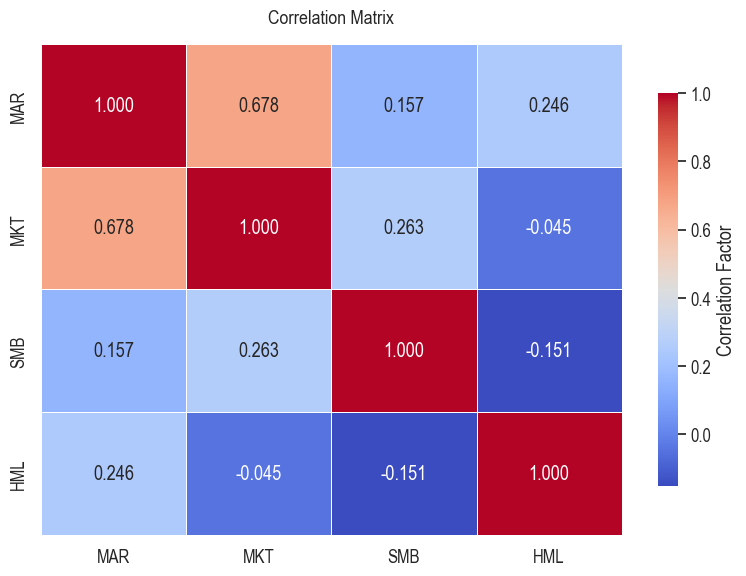

In [70]:
# Select the columns of interest (MAR, CRSP VW, SMB, HML)
all_data = z_m_df[['MAR', 'MKT', 'SMB', 'HML']]
# Calculate the correlation matrix
correlation_matrix = all_data.corr().round(3)

# Global Style
sns.set(style="white", font_scale=1.2)

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,          # affiche les valeurs dans les cases
    fmt=".3f",           # format des nombres
    cmap="coolwarm",     # palette de couleurs (alternatives : "viridis", "mako", "vlag")
    linewidths=0.5,      # lignes entre cases
    cbar_kws={"shrink": 0.8, "label": "Correlation Factor"}
)

plt.title("Correlation Matrix", fontsize=14, pad=15)
plt.tight_layout()
plt.show()
